In [1]:
import sys
sys.path.append("../")

import utils
from crbm import CRBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import subprocess as sp
import matplotlib.image as mpimg

In [2]:
# Directory of Stored CRBMs
mdir = "/mnt/D1/globus/cov_trained_crbms/"
rounds = [f"r{i}" for i in range(1, 13)]

#### Generate Weights

In [3]:
# generate weights in respective
for rid, round in enumerate([rounds[2]]):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = CRBM.load_from_checkpoint(checkp)
    utils.all_weights(tmp, name=version_dir +round)

../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (158400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [3]:
def assign(x):
    if x < 10:
        return "L" # low
    elif x < 1000:
        return "M" # medium
    else:
        return "H" # High

# Stores all data in a dictionary ("data")
all_data = am.fetch_data(rounds[2:], dir="../../cov", assignment_function=assign, threads=12)

Process Time 0.5036506652832031
Process Time 0.34093141555786133
Process Time 1.647186279296875
Process Time 0.9368007183074951
Process Time 1.8474082946777344
Process Time 0.562950849533081
Process Time 0.15518879890441895
Process Time 0.4079897403717041
Process Time 0.21656489372253418
Process Time 0.44737696647644043


In [7]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
for r in rounds[2:]:
    paths_u.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_seqlogo0", weight=False, outdir="./generated/"))
    paths_w.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_w_seqlogo0", weight=True, outdir="./generated/"))

<Figure size 2200x4500 with 0 Axes>

<Figure size 2200x4500 with 0 Axes>

<Figure size 2200x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

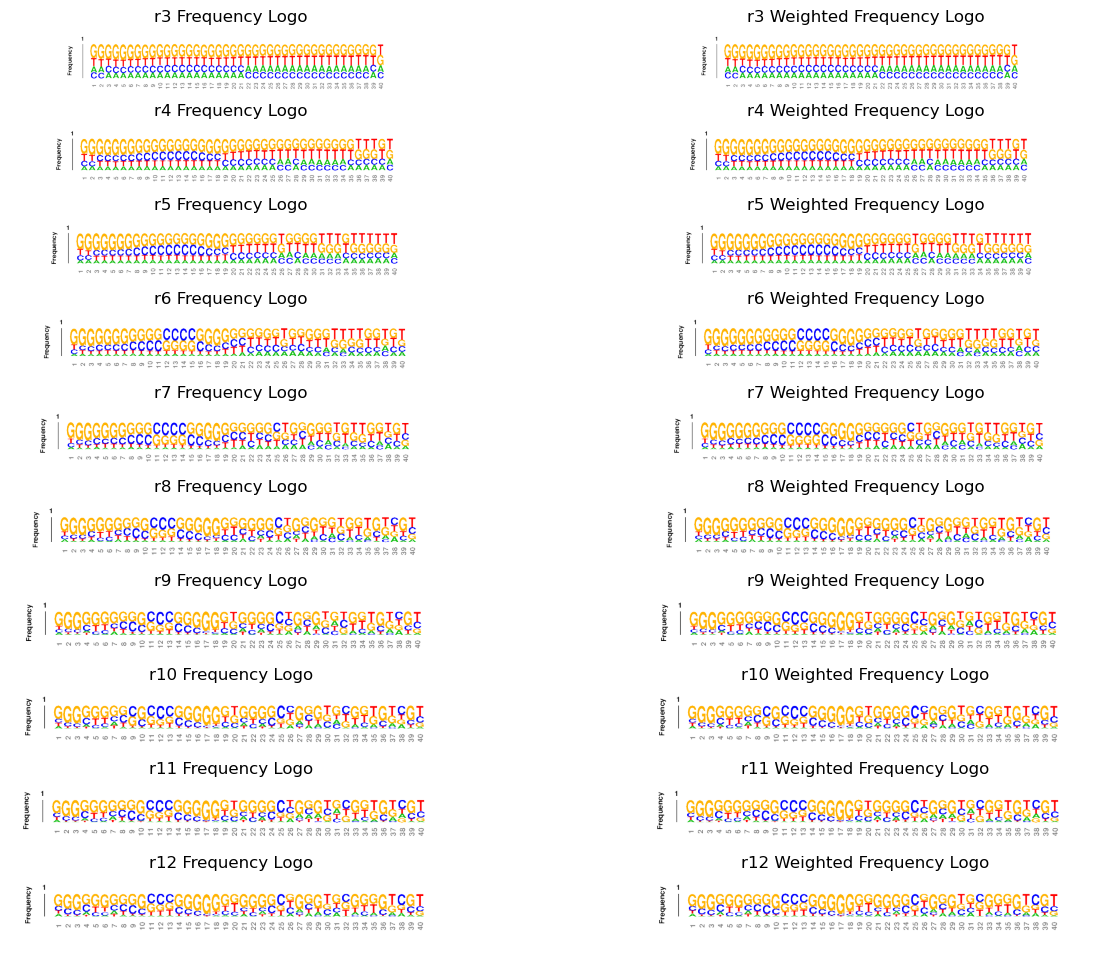

In [8]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds[2:]), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds[2:]):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

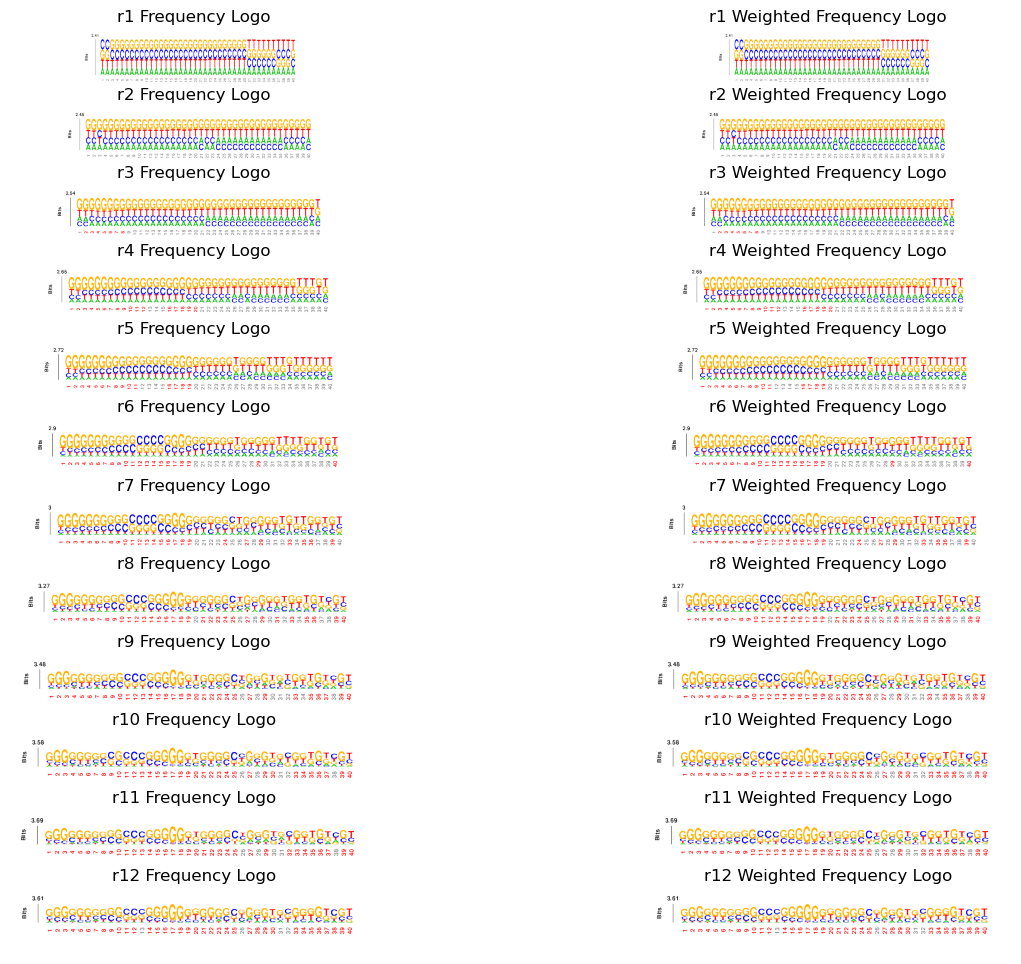

In [8]:
# Seq Logo showing Information of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.info.png")
    img2 = mpimg.imread(f"{paths_u[rid]}.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [ ]:
def count_dist(data_w_counts, title):
    fig, axs = plt.subplots(2, 1)
    sns.histplot(data=data_w_counts, ax=axs[0], x="round", hue="assignment", multiple="fill", palette="rocket", stat="percent")
    sns.histplot(data=data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    # sns.barplot(data=data_w_counts, ax=axs[0], x="round", y="copynum")
    plt.suptitle(title)
    plt.show()

count_dist(all_data, "Unique Sequence Count Distribution")

In [4]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r3", rbmdir=mdir)
r3_crbm = CRBM.load_from_checkpoint(checkp)

In [5]:
# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(rounds[2::2], r3_crbm, all_data, "crbm_r3_v2")

KeyboardInterrupt: 

In [5]:
r3_likelihoods = am.get_likelihoods("./generated/crbm_r3_v2.json")

In [18]:
r3_likelihoods["likelihoods"].keys()

dict_keys(['r3', 'r5', 'r7', 'r9', 'r11'])

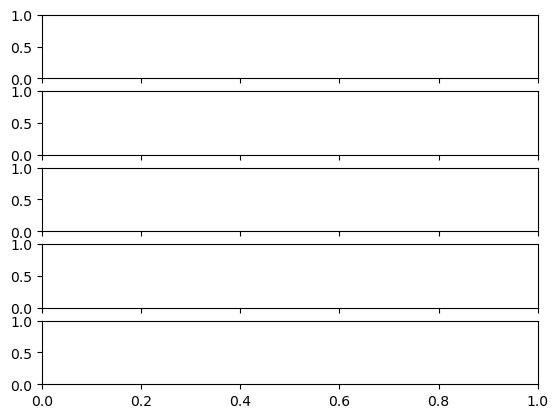

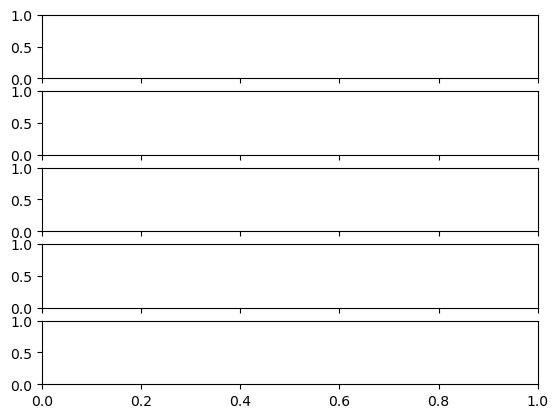

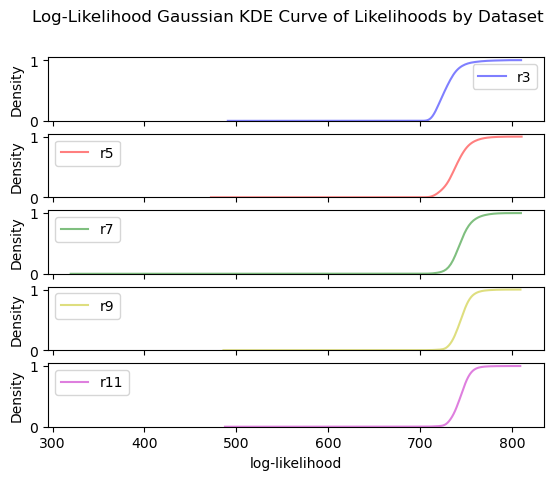

In [19]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(r3_likelihoods["likelihoods"], rounds[2::2], rounds[2::2], xlim=None, cdf=True)

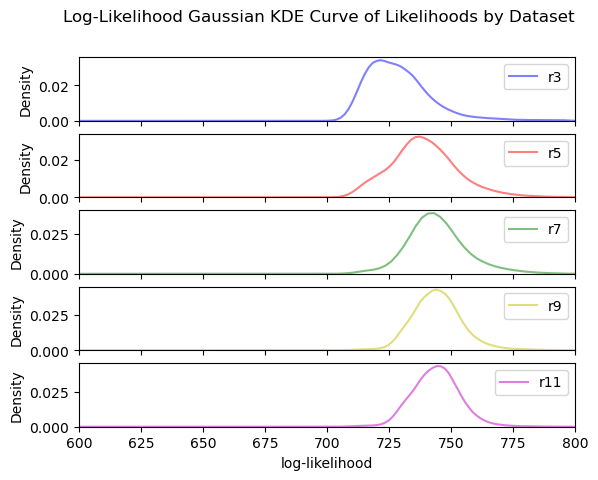

In [21]:
am.plot_likelihoods(r3_likelihoods["likelihoods"], rounds[2::2], rounds[2::2], xlim=(600, 800), cdf=False)

In [22]:
print(r3_crbm.log_Z_AIS, r3_crbm.log_Z_AIS_std)

tensor(2259.2406) tensor(0.6542)


In [17]:
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in path.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# bounds listed in ascending order
def multi_peak_seq_log_fig(data, likelihoods, round, bounds, weight=False, title=None, xlim=None):
    data_subsets, seqlogo_paths = [], []
    for iid,  i in enumerate(bounds):
        sub = am.data_subset(data, likelihoods, round, i[0], i[1])
        seqlogo_paths.append(am.seq_logo(sub, f"peak{iid+1}_likeli_{round}", weight=weight, outdir="./generated/"))
        data_subsets.append(sub)

    peak_num = len(bounds)
    gs_kw = dict(width_ratios=[1 for x in range(peak_num)], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['top' for x in range(peak_num)], [f'lower{x}' for x in range(peak_num)]],
                                  gridspec_kw=gs_kw, figsize=(15, 5), constrained_layout=False)

    axd["top"].set_xlim(*xlim)
    sns.kdeplot(likelihoods[round], ax=axd["top"])

    path = axd["top"].get_children()[0].get_path()

    for iid, i in enumerate(bounds):
         shaded_kde_curve(axd["top"], path, i[0], i[1], am.supported_colors[iid])

    axd["top"].set_xlabel("log-likelihood")
    for iid, i in enumerate(bounds):
        color_subplot(axd[f"lower{iid}"], am.supported_colors[iid])
        seqlogo_subplot(axd[f"lower{iid}"], seqlogo_paths[iid])

    if title is None:
        fig.suptitle(title)
    else:
        fig.suptitle(f"Composition of peaks across RBM Likelihood of Round{round}")

    plt.show()



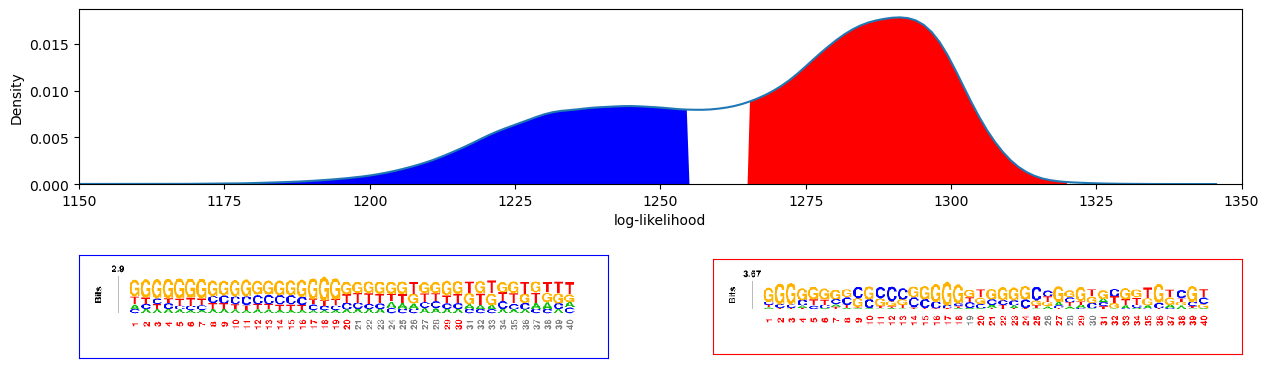

In [19]:
multi_peak_seq_log_fig(all_data, r12_likelihoods["likelihoods"], "r8", [[1180, 1255], [1265, 1320]], weight=False, xlim=(1150, 1350))

In [21]:
exp_seqs = {
    "SP5": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        new_char = np.random.choice(["A", "C", "G", "T"])
        # new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs
rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
rand_exp_pd = pd.DataFrame(rand_exp_set)

exp_A_seqs = {
    "SP5":       'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6":       "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7":       "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C":      'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":     "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA",
    "SP634G":    "ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA",
    "SP634C":    "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA",
    "SP634A":    "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA",
    "SP630":     "AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA",
    "SP619":     "AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA",
    "r12_align": "AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTTGATT"
}
exp_A_set = {'id':list(exp_A_seqs.keys()), 'sequence':list(exp_A_seqs.values())}
exp_A_pd = pd.DataFrame(exp_A_set)


exp_set = {'id':list(exp_seqs.keys()), 'sequence':list(exp_seqs.values())}
exp_pd = pd.DataFrame(exp_set)

In [22]:
# exp_2_seqs, exp_2_likelis = r2_rbm.predict(exp_pd)
# exp_2_A_seqs, exp_2_A_likelis = r2_rbm.predict(exp_A_pd)
exp_12_seqs, exp_12_likelis = r12_crbm.predict(exp_pd)
exp_12_rand_seqs, exp_12_rand_likelis = r12_crbm.predict(rand_exp_pd)

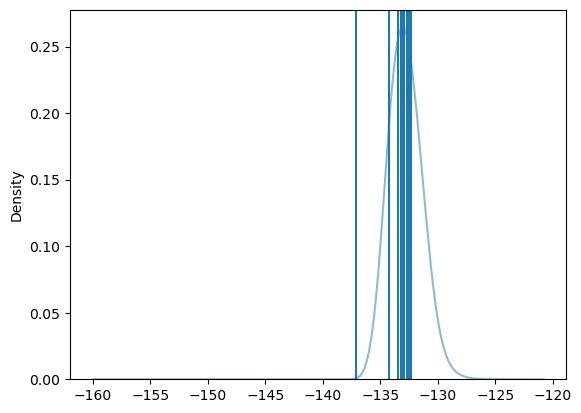

In [17]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r2_likelihoods["likelihoods"]["r2"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_2_A_likelis:
    plt.axvline(likeli)
plt.show()

In [18]:
for i in range(len(exp_seqs)):
    print(exp_2_A_seqs[i], exp_2_A_likelis[i])

TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.68197807155985
CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.51246189410242
CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG -132.31719745223856
CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT -132.93433717970836
AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA -133.00513372045458
AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA -132.61341545160053
AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA -133.42270537788107
AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA -133.18874658196373
AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA -134.20747154167958
AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA -137.0695806022038


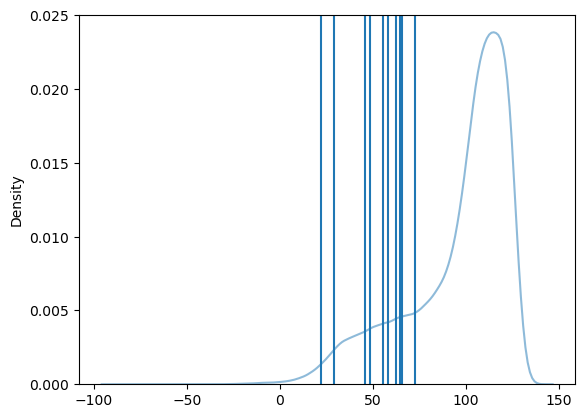

In [23]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r12_likelihoods["likelihoods"]["r12"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_12_rand_likelis:
    plt.axvline(likeli)
plt.show()

In [26]:
labels = list(exp_seqs.keys())
for i in range(len(exp_seqs)):
    print(labels[i], exp_12_rand_seqs[i], exp_12_rand_likelis[i])

SP5 ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 64.73579162895203
SP6 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 65.80233227010103
SP7 CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT 72.53920118164251
SP6C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT 57.84669211258779
SP634 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTCGTC 55.16241277357608
SP634G CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGGCCGCA 62.09695458333567
SP634C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCGGCTG 48.45978498541854
SP634A CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGCGTCTA 45.62802930557973
SP630 GTTCATGGTAGGTATTGCATGGTAGGGATAGTGGCTACTA 22.086382808362487
SP619 ACAGCGGGTTGTTATTGCATGGTAGGGATAGTGTTCTCCG 29.17192714906423


In [20]:
r12_likelihoods.keys()

dict_keys(['likelihoods', 'sequences'])

In [28]:
lik = r12_likelihoods["likelihoods"]["r12"]
seq = r12_likelihoods["sequences"]["r12"]

for lid, l in enumerate(lik):
    if l > 130:
        print(seq[lid])

AGGCTTATGGCCTGGGGGGGGGGCCCGGGTGGGGGGTCGT
TGGATTATCGCCGGGGGGGGGGGCCCGGGTGGGGGGTCGT
CGGCTAATCGTCCGGGGGGGGGGCCCGGGTGCGGGGTCGT
CGGCTTAGCGTCGGGGGGGGGGGCCGGGGGGGGGGGTCGT
AGGCTTAGCGTCCGGGGGGGGGGCCCGGGTGGGGGGTCGT
GCCCGGCGGGCTGGGGGGGGGGGGTGGGGTGGGGGGTCCT
TGGCTTATGGCCGGGGGGGGGGGCCCGGGTGCGGGGTCGT
GGGGGCGCCCCCCCCCCCCGGGGGTCGTTTCTACAGTGGG
TGGCTTATCGTCTGGGGGGGGGGCCGGGGTGGGGGGTCGT
CCCCCCCGGCCTGGGGGGGGGGGTTGGGGGGGGGGGTCCT
CCCCCCCCGCCTCGGGGGGGGGGGTGGGGTGGGGGGTCCT
GGGCTTAGCGTCGGGGGGGTGGGCCGGGGTGCGGGGTCGT
AGGTTTATGGTCGGGGGGGGGGGCCGGGGTGCGGGGTCGT
CCCCCGCGGGTTGGGGGGGGGGGGTGGGGGGCGGGGTCCT
GGGGGGGCCGGCTCGGGAATGGGGTCGTTTCTACAGTGGG
CCCCCGCCGGCTTGGGGGGGTGGTTTGGGTGGGGGGTCCT
CCCCCGCCGGCTGGGGGGGGGGGGGGGGGGGGGGGGTCCT
TGGTTTAGGGCCGGGGGGGGGGGCCGGGGTGGGGGGTCGT
CCCCGGCGGGCTGGGGGGGGTGGGTTGGGTGGGGGGTCCT
CGGATAATCGTCCGGGGGGGGGGCCCGGGTGGGGGGTCGT
CCCCCGCGGGTTGGGGGGGGGGGTTTGGGTTCGGGGTCCT
TGGGGGGGTGGGTAGGGAATGGGGTCGTTTCTACAGTGGG
GGGCTTACCGCCTGGGGGGGGGGCCGGGGTGCGGGGTCGT
CCCCCGCCGGCTGGGGGGGGGGGTCTGGGTGGGGGGTCCT
AGGCTTATCGTCTGGG

##Clustering with the r12 RBM

In [5]:
import torch

def clean_ax(ax):
    ax.axis("off")

def dataframe_to_input_crbm(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten

# Inputs across the k dimension (separate convolutions, same convolution weight)
def data_with_weights_plot(crbm, dataframe, hidden_key, hidden_unit_numbers, kdim="mean", data="cgf", data_range=None):
    if data not in ["cgf", "mean"]:
        print(f"Data Type {data} not supported!")
        exit(-1)

    if hidden_key not in crbm.hidden_convolution_keys:
        print(f"Hidden Convolution Key {hidden_key} not found!")
        exit(-1)

    # Convert Sequences to one hot encoding Format and Compute Hidden Unit Input
    base_to_id = am.int_to_letter_dicts[crbm.molecule]
    data_tensor, weights = dataframe_to_input_crbm(dataframe, base_to_id, crbm.v_num, crbm.q, weights=True)
    input_hiddens = crbm.compute_output_v(data_tensor) # List of Iuk matrices

    weight_index = crbm.hidden_convolution_keys.index(hidden_key)  # Get index of Weight for accessing input_hiddens list
    input_W_hiddens = input_hiddens[weight_index] # Get the hidden inputs for this particular weight

    Wdims = crbm.convolution_topology[hidden_key]["weight_dims"]  # Get dimensions of W matrix
    h_num = Wdims[0]
    beta, W = utils.get_beta_and_W(crbm, hidden_key, include_gaps=False)   # Get Beta and sort hidden Units by Frobenius Norms
    order = np.argsort(beta)[::-1]

    ### Reduction of the k dimension, or alternatively view all
    if kdim in ["mean", "sum"]:
        if kdim == "mean":
            input_W_hiddens = input_W_hiddens.mean(2)
        if kdim == "sum":
            input_W_hiddens = input_W_hiddens.sum(2)
        gs_kw = dict(width_ratios=[3, 1], height_ratios=[1 for x in hidden_unit_numbers])
        grid_names = [[f"weight{i}", f"cgf{i}"] for i in range(len(hidden_unit_numbers))]
        # Make Figure
        fig, axd = plt.subplot_mosaic(grid_names, gridspec_kw=gs_kw, figsize=(10, 5*len(hidden_unit_numbers)), constrained_layout=True)
    elif kdim == "full":
        convx = input_W_hiddens.shape[2]
        subcol_num = convx // 2
        if convx - (subcol_num*2) != 0:
            even = False
            # Uneven column sizes, add extra plot which we won't use
            grid_names = [[f"weight{i}", [[f"cgf{i}_{j}" for j in range(0, convx//2 + 1)], [f"cgf{i}_{j}" for j in range(convx//2 + 1, convx + 1)]]] for i in range(len(hidden_unit_numbers))]
        else:
            even = True
            grid_names = [[f"weight{i}", [[f"cgf{i}_{j}" for j in range(0, convx//2)], [f"cgf{i}_{j}" for j in range(convx//2, convx)]]] for i in range(len(hidden_unit_numbers))]
        # Make Figure
        fig, axd = plt.subplot_mosaic(grid_names, figsize=(10, 5*len(hidden_unit_numbers)), constrained_layout=True)
    else:
        print(f"Kdim argument must be mean, sum, or full. {kdim} Not Supported")
        exit(-1)

    # Prepare Line Data to be plot, must be either cgf or mean
    if data == "cgf":
        npoints = 1000  # Number of points for graphing CGF curve
        lims = [(np.sum(np.min(w, axis=1)), np.sum(np.max(w, axis=1))) for w in W]  # Get limits for each hidden unit
        data_range = torch.zeros((npoints, h_num))
        # change this to data_range?
        for i in range(h_num):
            x = lims[i]
            data_range[:, i] = torch.tensor(np.linspace(x[0], x[1], num=npoints).transpose())

        pre_cgf = crbm.cgf_from_inputs_h(data_range, hidden_key)
        line_data = pre_cgf.detach().numpy()
        range_data = data_range.detach().numpy()

    elif data == "mean":
        I = input_W_hiddens
        I_min, inds = I.min(dim=0)
        I_max, inds = I.max(dim=0)
        I_min.unsqueeze_(0)
        I_max.unsqueeze_(0)
        if I.dim() == 3:
            data_range = (I_max-I_min) * torch.arange(0,1+0.01,0.01).unsqueeze(1).unsqueeze(2) + I_min
        elif I.dim() == 2:
            data_range = (I_max-I_min) * torch.arange(0,1+0.01,0.01).unsqueeze(1) + I_min

        mean = crbm.mean_h(data_range, hidden_key)
        line_data = mean.detach().numpy()
        range_data = data_range.detach().numpy()

    # Convewrt to Numpy for Graphing
    input_W_hiddens = input_W_hiddens.detach().numpy()

    for hid, hu_num in enumerate(hidden_unit_numbers):
        ix = order[hu_num]  # get hidden units by frobenius norm order (look at get_beta_and_W)
        # Make Sequence Logo
        rbm_utils.Sequence_logo(W[ix], ax=axd[f"weight{hid}"], data_type="weights", ylabel=f"Weight #{hu_num}", ticks_every=5, ticks_labels_size=14, title_size=20, molecule=crbm.molecule)

        if kdim != "full":
            t_x = np.asarray(range_data[:, ix])
            t_y = np.asarray(line_data[:, ix])
            deltay = np.min(t_y)
            counts, bins = np.histogram(input_W_hiddens[:, ix], bins=100, weights=weights)
            factor = np.max(t_y) / np.max(counts)
            # WEIGHTS SHOULD HAVE SAME SIZE AS BINS
            axd[f"cgf{hid}"].hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                       histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
            axd[f"cgf{hid}"].plot(t_x, t_y - deltay, lw=3, color='C1')
            axd[f"cgf{hid}"].tick_params(axis='both', direction='in', length=6, width=2, colors='k')
            axd[f"cgf{hid}"].tick_params(axis='both', labelsize=16)
            axd[f"cgf{hid}"].yaxis.tick_right()
            axd[f"cgf{hid}"].yaxis.set_label_position("right")

            if data == "cgf":
                axd[f"cgf{hid}"].set_ylabel('CGF', fontsize=18)

        else:
            t_x = np.asarray(range_data[:, ix])
            t_y = np.asarray(line_data[:, ix])

            if data == "cgf":
                axd[f"cgf{hid}_{0}"].set_ylabel('CGF', fontsize=10)
                deltay = np.min(t_y)
            elif data == "mean":
                deltay = np.min(t_y, axis=1)

            axd[f"cgf{hid}_{0}"].yaxis.set_label_position("left")
            axd[f"cgf{hid}_{0}"].tick_params(axis='both', direction='in', length=6, width=2, colors='k')

            for j in range(convx):
                counts, bins = np.histogram(input_W_hiddens[:, ix, j], bins=100, weights=weights)
                factor = np.max(t_y) / np.max(counts)
                axd[f"cgf{hid}_{j}"].hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                           histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)

                if data == "mean":
                    axd[f"cgf{hid}_{j}"].plot(t_x[:, j], t_y[:, j] - deltay[j], lw=3, color='C1')
                else:
                    axd[f"cgf{hid}_{j}"].plot(t_x, t_y - deltay, lw=3, color='C1')

                axd[f"cgf{hid}_{j}"].tick_params(axis='both', labelsize=8)
                axd[f"cgf{hid}_{j}"].yaxis.tick_right()

                if not even and j == convx - 1:  # Last Plot that contains nothing
                    clean_ax(axd[f"cgf{hid}_{j+1}"])
    plt.show()


In [25]:
import analysis_methods_crbm as am_crbm

../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


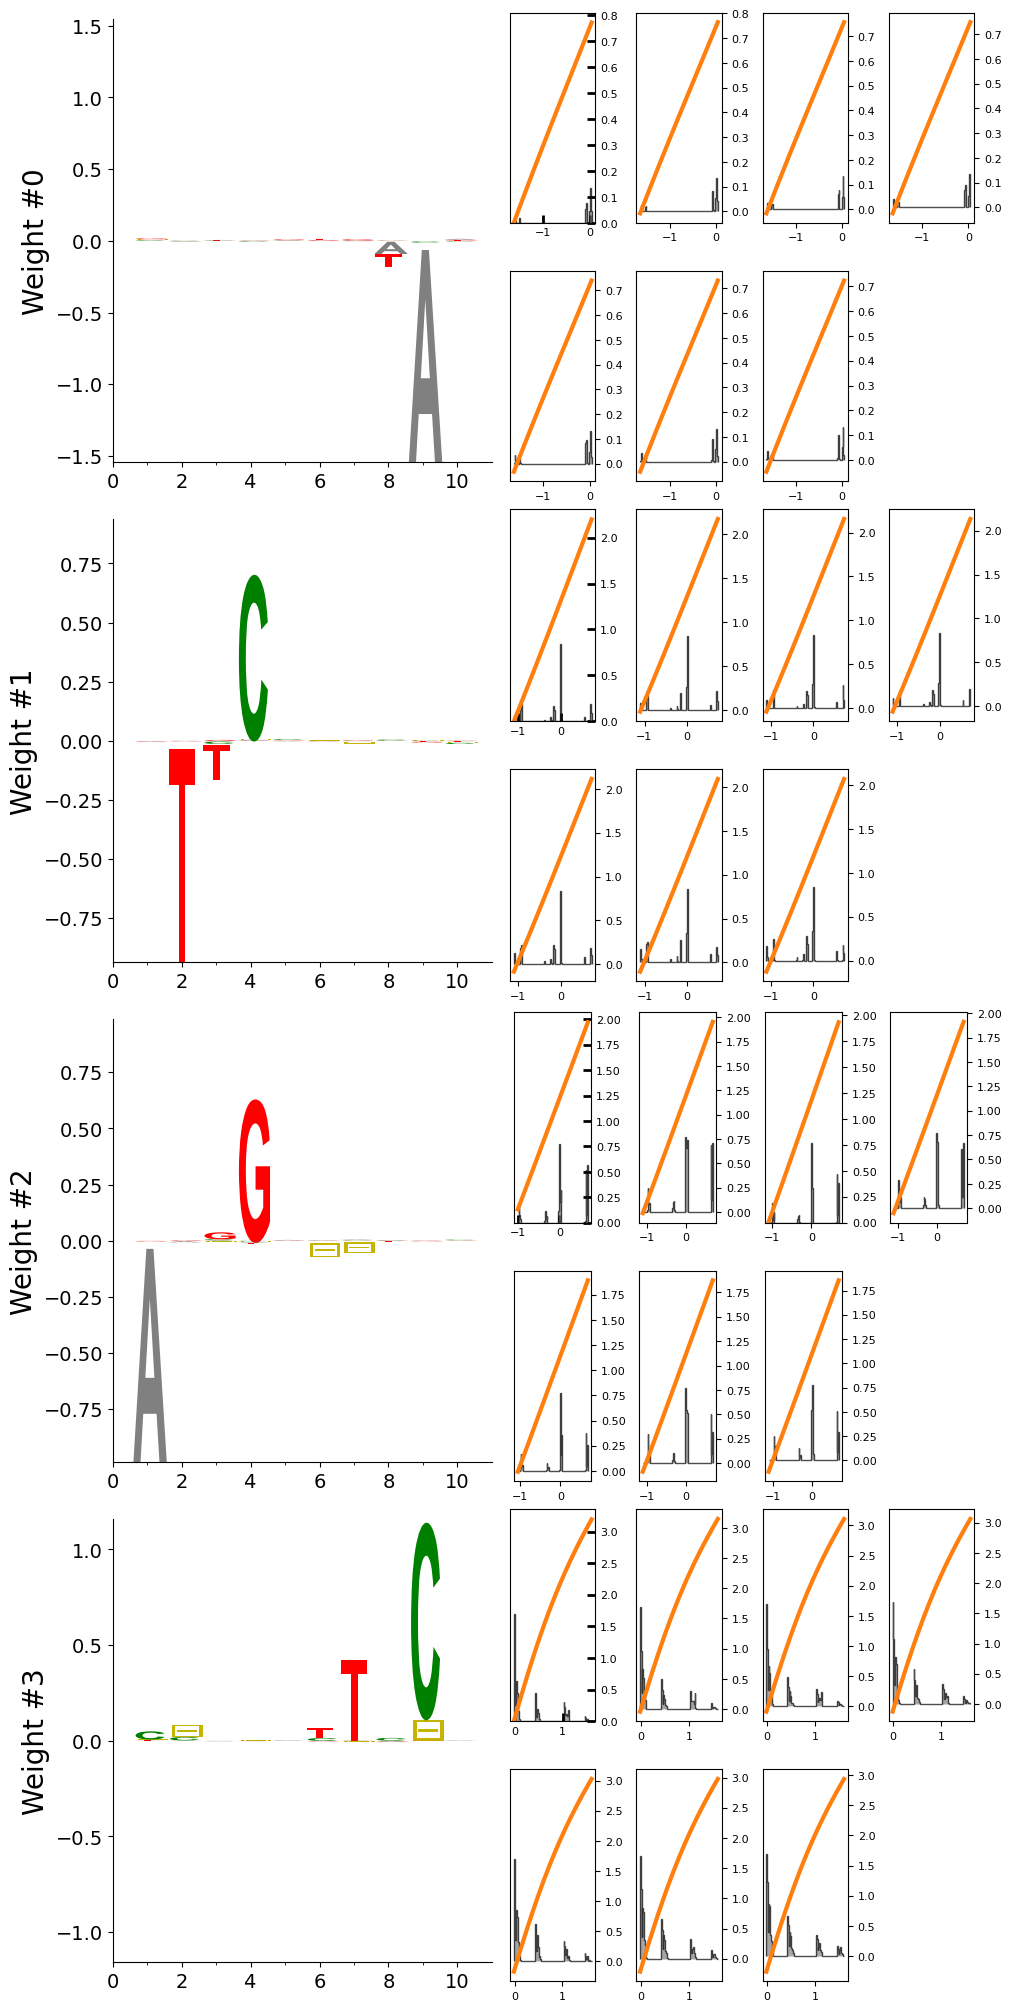

In [26]:
am_crbm.data_with_weights_plot(r3_crbm, all_data[all_data["round"] == "r3"], "hidden1", [0, 1, 2, 3], kdim="full", data="mean")

../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils

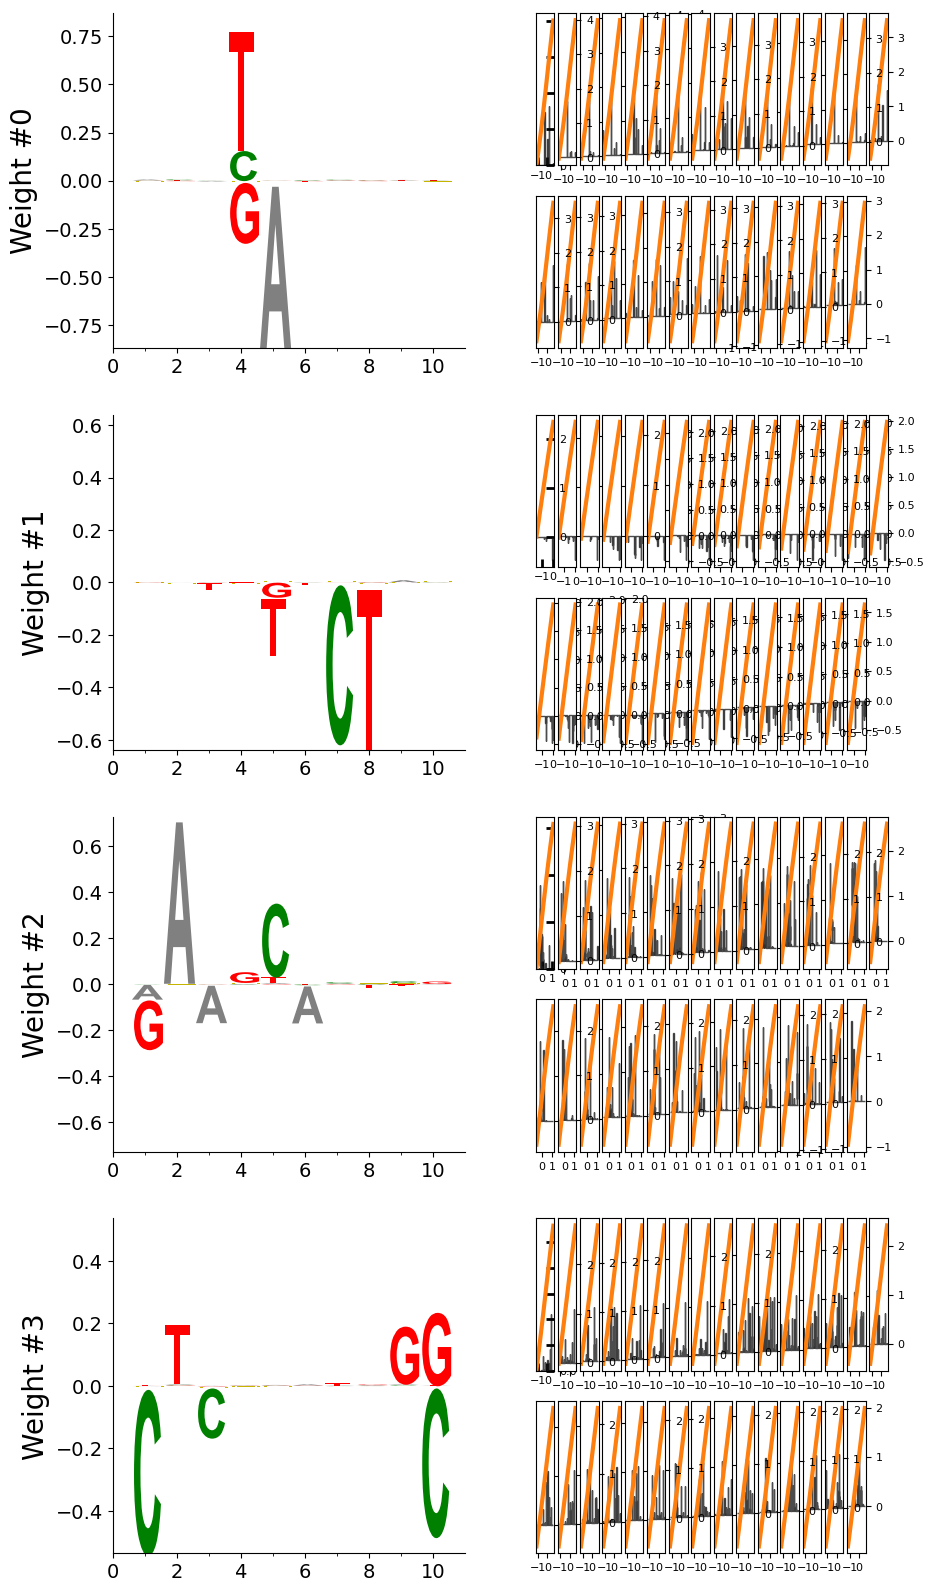

In [27]:
am_crbm.data_with_weights_plot(r3_crbm, all_data[all_data["round"] == "r12"], "hidden2", [0, 1, 2,3], kdim="full", data="mean")

In [28]:
am_crbm.data_with_weights_plot(r3_crbm, all_data[all_data["round"] == "r12"], "hidden3", [0, 1, 2, 3], kdim="mean", data="mean")

NameError: name 'data_with_weights_plot' is not defined

In [7]:
r12_data = all_data[all_data["round"] == "r12"]
# print(r12_data)

In [6]:
r12_copynum = r12_data.copynum.tolist()

In [9]:
r12_by_copynum = r12_data.sort_values("copynum", ascending=False)

Clustering by Inputs on hidden nodes

In [6]:
import torch

def dataframe_to_input_crbm(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten

# Produces flat vector of Inputs of each hidden unit (reduced over the convolution dimension (k) by sum or mean)
def flatten_and_reduce_input(Ih, reduction="sum"):
     # Iuk (Batch, hidden number (u), conv number (k))
    if reduction == "sum":
        return torch.cat([Iuk.sum(2) for Iuk in Ih], 1)
    elif reduction == "mean":
        return torch.cat([Iuk.mean(2) for Iuk in Ih], 1)
    else:
        print(f"Reduction {reduction} not supported", file=sys.stderr)
        exit(-1)

def prepare_input_vector(crbm, dataframe):
    if type(dataframe) == pd.DataFrame:
        base_to_id = am.int_to_letter_dicts[crbm.molecule]
        data_tensor = dataframe_to_input_crbm(dataframe, base_to_id, crbm.v_num, crbm.q, weights=False)
    elif type(dataframe) == torch.Tensor:
        data_tensor = dataframe
    input_hiddens = crbm.compute_output_v(data_tensor) # List of Iuk matrices
    return flatten_and_reduce_input(input_hiddens).detach().numpy()

In [7]:
# Primary Component Analysis
from sklearn.decomposition import PCA
import clustering_methods as  cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

r3_data = all_data[all_data["round"] == "r3"]

r3_input = prepare_input_vector(r3_crbm, r3_data)
scaler = StandardScaler()
input_r3_processed = scaler.fit_transform(r3_input)
X_r3 = input_r3_processed

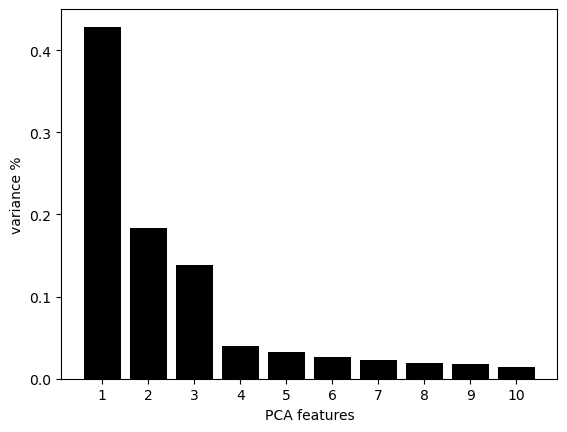

In [8]:
cm.pca_component_check(X_r3, components=10)

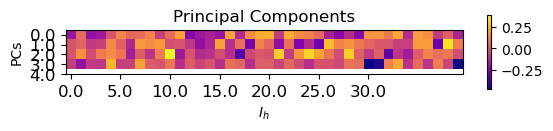

In [8]:
# We will do the first 4 components only, Drop in variance at feature 5

pca_r3 = PCA(n_components=4)
principal_components = pca_r3.fit_transform(X_r3)
PCA_components_pd_r3 = pd.DataFrame(principal_components)
components = pca_r3.components_
cm.view_components(components)


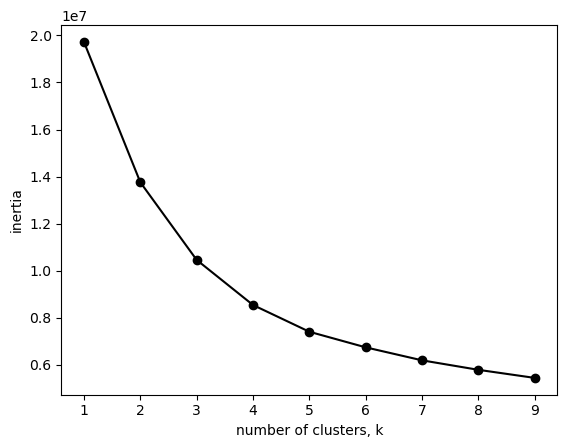

In [10]:
# KMeans on Transformed Sequences
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_pd_r3.iloc[:, :4])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [9]:
# Elbow Point is at 5 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=5, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r3_data.reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:1, 1:2, 2:3, 3:4, 4:5})

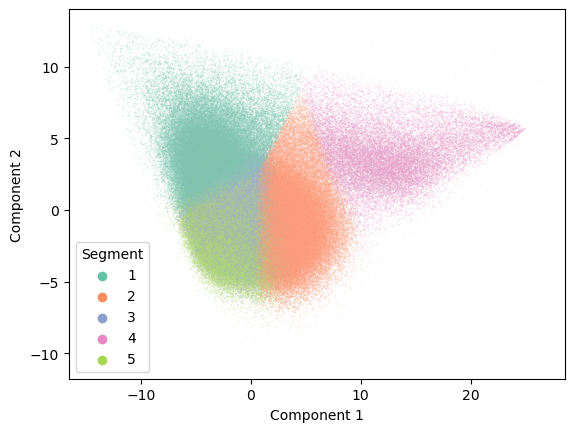

In [10]:
# colors = ['#747FE3', '#8EE35D', '#E37346']
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.2, s=1, palette="Set2")
plt.show()

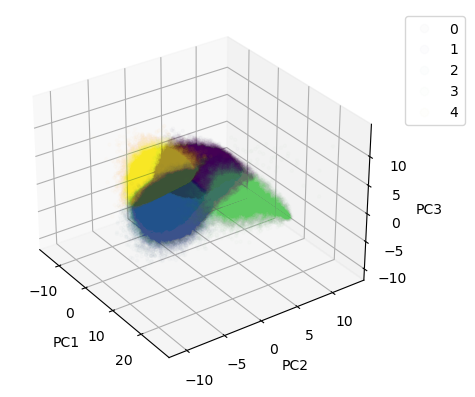

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, -35)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

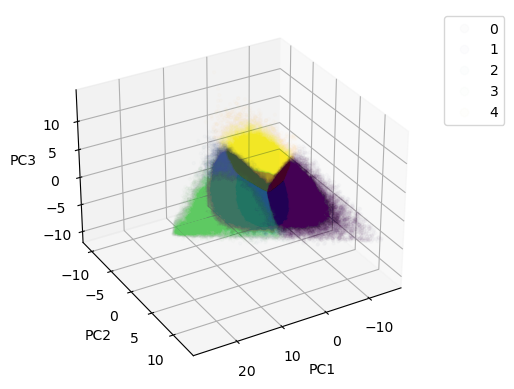

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 60)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

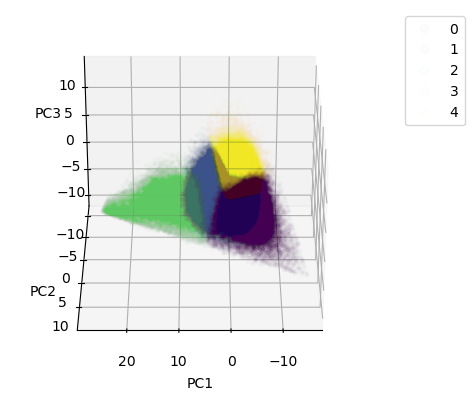

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 90)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

Now we need to see what the primary components are learning

In [83]:
# Basic Idea
# Add weights of inputs with additional weighting of the weights (lol) by the primary components

r12_beta, r12_W = get_beta_and_W(r12_rbm)


In [91]:
prod_1 = r12_W*components[0][:, None, None]
avg_W = prod_1.mean(axis=0)

In [108]:
def pca_avg_weights(W, components, molecule="dna"):
    pcs = components.shape[0]
    v_num = W.shape[1]
    fig, axs = plt.subplots(pcs, 1, figsize=(int(v_num/5), 3*pcs))
    fig.suptitle("PCA Average Weights")
    products = np.zeros((pcs, *W.shape[1:]), dtype=np.float)
    for i in range(pcs):
        prod = W*components[i][:, None, None]
        products[i] = prod.mean(axis=0)
        ax = axs[i]
        rbm_utils.Sequence_logo(products[i], ax=ax, data_type="weights", ylabel=f"PC{i+1}", show=False, molecule=molecule, ticks_every=10)
    plt.show()
    return products



In [122]:
def get_sequences_from_W(W_matrix, base_to_id, gaps=True):
    max_seqs, min_seqs = [], []
    inv_base_to_id = {v: k for k, v in base_to_id.items()}
    if not gaps:
        W_matrix = W_matrix[:, :, :-1]
    for i in range(W_matrix.shape[0]):
        max_seq_int = list(np.argmax(W_matrix[i], axis=1))
        min_seq_int = list(np.argmin(W_matrix[i], axis=1))
        max_seq = "".join([inv_base_to_id[x] for x in max_seq_int])
        min_seq = "".join([inv_base_to_id[x] for x in min_seq_int])
        max_seqs.append(max_seq)
        min_seqs.append(min_seq)
    return max_seqs, min_seqs

../rbm_utils.py:439: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


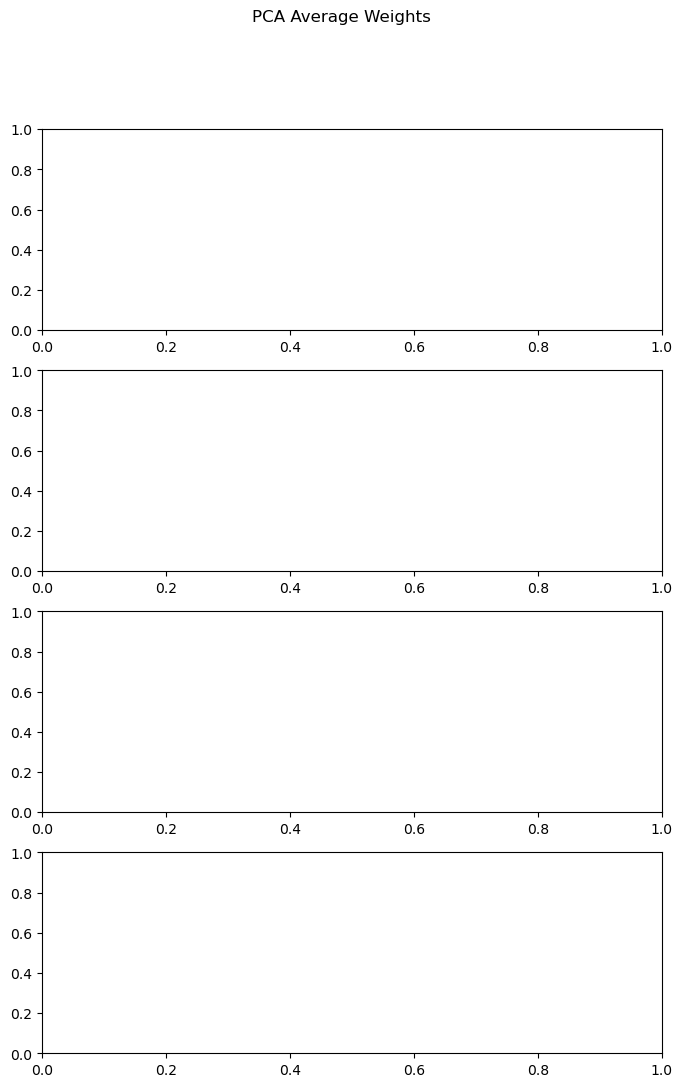

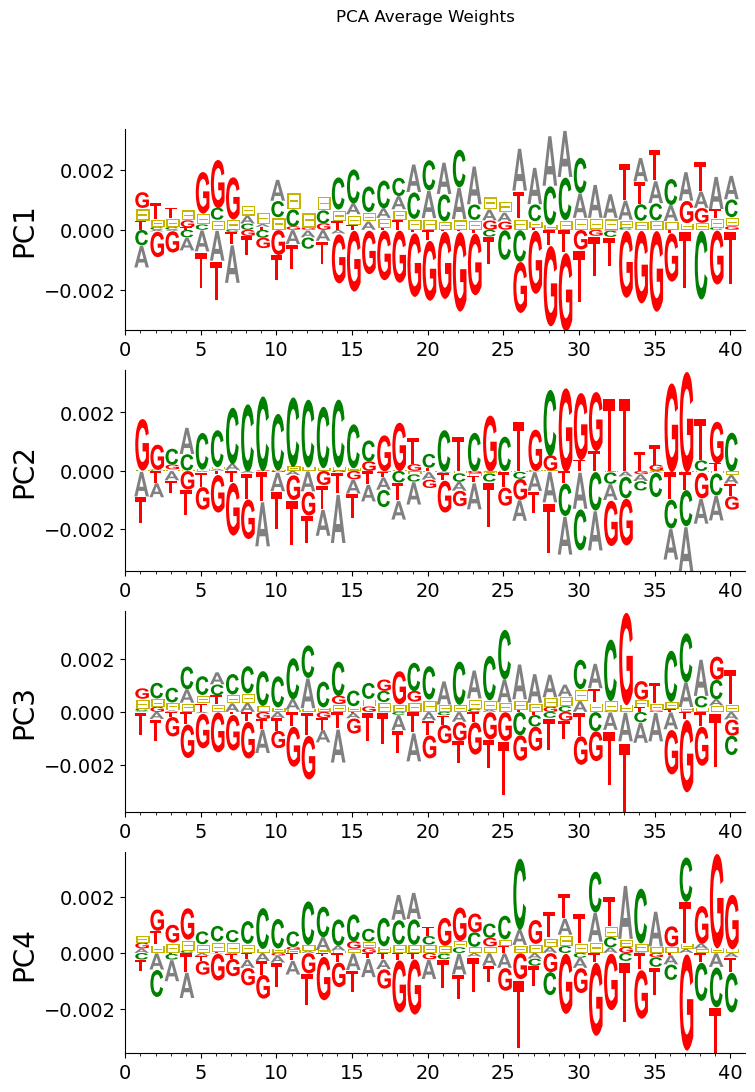

In [109]:
avg_W = pca_avg_weights(r12_W, components, molecule="dna")

In [119]:
max_seqs, min_seqs = get_sequences_from_W(avg_W, rbm_utils.dnadictU, gaps=True)

In [120]:
max_seqs

['GTT-GGG--A---CCCCCACACA--AAAACAATATCATAA',
 'GGCACCCCCCCCCCCCGGTCCTCGCTGCGGGTTTTGGTGC',
 'GCCCCACCCCCCCCCCGGCCACACCAAAACACGGTCCAGT',
 '-GGGCCCCCCCCCCCCCAATGGGCCCGTTTCTACAGCGGG']

In [121]:
min_seqs

['AGGATTATGTTCTGGGGGGGGGGTCGGGGTTTGGGGTCGT',
 'TATTGGGGATTTAATACAAGGGATGATTACAGGCCAAAAG',
 'TTGGGGGGAGGGAAGTTTAGGTGTTGGTTGGTTAAGGGTC',
 'TCAAGGGGGTATGGTAGGGATTTTGTTCGGGGTGTCGCTC']

In [125]:
max_seqs_no_g, min_seqs_no_g = get_sequences_from_W(avg_W, rbm_utils.dnadictU, gaps=False)

In [126]:
max_seqs_no_g

['AGGATTATGTTCTGGGGGGGGGGTCGGGGTTTGGGGTCGT',
 'TATTGGGGATTTAATACAAGGGATGATTACAGGCCAAAAG',
 'TTGGGGGGAGGGAAGTTTAGGTGTTGGTTGGTTAAGGGTC',
 'TCAAGGGGGTATGGTAGGGATTTTGTTCGGGGTGTCGCTC']

Let's try the same exact thing on round 2 now

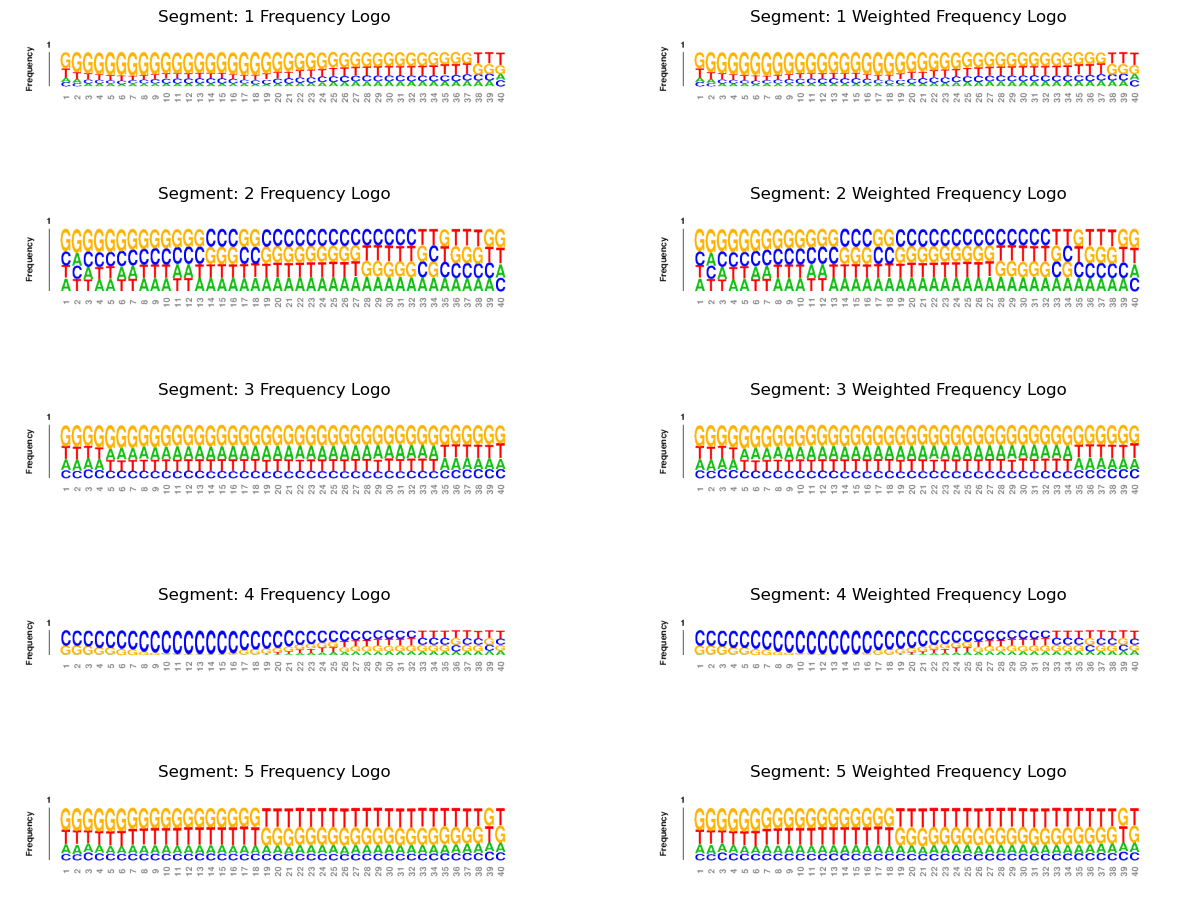

In [28]:
segments = [1, 2, 3, 4, 5]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"r3_pcak_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"r3_pcak_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

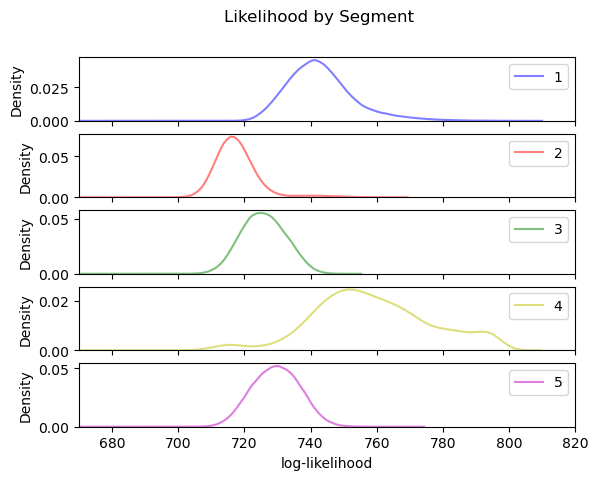

In [32]:
segments = [1, 2, 3, 4, 5]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = r3_likelihoods["likelihoods"]["r3"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=(670, 820))

In [37]:
seg1 = df_pca_kmeans[df_pca_kmeans["Segment"] == 1].sort_values("likelihood", axis=0, ascending=False)
seg1.head(20)

sequence  copynum round assignment  \
348786  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGT      1.0    r3          L   
523767  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGC      1.0    r3          L   
516450  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTCA      2.0    r3          L   
203442  TGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG      1.0    r3          L   
233531  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCTTTTTT      1.0    r3          L   
380346  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTTGGTTC      1.0    r3          L   
263616  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTTAGGGGTT      1.0    r3          L   
292190  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGATC      1.0    r3          L   
476183  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTTAAGGA      1.0    r3          L   
601291  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTGGGGTTC      1.0    r3          L   
174251  TTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG      1.0    r3          L   
75152   GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTCTTAC      1.0    r3          L   
276813  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGGTTTGT      1.0    r3          L   
507256  GGGGGGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG      1.0    r3          L   
418631  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTTGTGTTTTA      1.0    r3          L   
617405  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCC      1.0    r3          L   
326828  GGGGGGGGGCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGT      1.0    r3          L   
416939  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTGGGTCGGGG      1.0    r3          L   
316119  GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTGGTCTTCT      1.0    r3          L   
272572  GGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGA      1.0    r3          L   

        Component 1  Component 2  Component 3  Component 4  K-mean PCA Label  \
348786   -14.522794    12.801528    -3.661688     2.976982                 0   
523767   -14.364869    12.826536    -3.884055     2.991588                 0   
516450   -13.834294    12.697530    -3.288019     1.935984                 0   
203442   -14.502833    12.610630    -3.833320     3.174849                 0   
233531   -12.300011    11.287286    -1.026097     0.332045                 0   
380346   -13.370855    11.674782    -1.885966     1.250082                 0   
263616   -13.243456    10.921430    -2.367718     0.888481                 0   
292190   -14.021016    12.657831    -3.510707     2.157017                 0   
476183   -13.129594    11.548788    -2.867525     1.432484                 0   
601291   -13.734066    11.943503    -2.474227     1.598150                 0   
174251   -14.439570    12.207572    -3.916299     3.415199                 0   
75152    -12.799001    11.670117    -2.325040     0.641673                 0   
276813   -12.711161    11.569751    -1.967731     1.315049                 0   
507256   -14.180907    11.810326    -3.295502     3.411782                 0   
418631   -12.388861    10.096055     0.186178    -0.099719                 0   
617405   -13.505671    12.843043    -3.837708     1.983956                 0   
326828   -13.508618    12.579070    -3.533047     3.223128                 0   
416939   -13.152905    11.744819    -2.477946     1.858374                 0   
316119   -12.339725    11.134075    -1.253589     0.316058                 0   
272572   -13.943875    11.609289    -3.240919     3.637446                 0   

        Segment  likelihood  
348786        1  806.873397  
523767        1  804.864833  
516450        1  804.453230  
203442        1  804.090908  
233531        1  803.829864  
380346        1  803.655365  
263616        1  802.654647  
292190        1  802.595454  
476183        1  802.225209  
601291        1  802.006921  
174251        1  801.399467  
75152         1  800.482286  
276813        1  800.450928  
507256        1  800.322247  
418631        1  799.958055  
617405        1  799.891155  
326828        1  799.743982  
416939        1  799.667158  
316119        1  799.200878  
272572        1  798.771113

In [38]:
seg2 = df_pca_kmeans[df_pca_kmeans["Segment"] == 2].sort_values("likelihood", axis=0, ascending=False)
seg2.head(20)

sequence  copynum round assignment  \
128060  GGGGGGGGGGGGGGGGCCCCCCCCCCCCCGTAGACTCGGA      1.0    r3          L   
77393   GGGGGGGGGGCCCCCCCCCCCCTCGGGGAGTTTGTGTTTC      1.0    r3          L   
186563  CCCCCCCCCCCCCCCCGGGGGGGGCGTGATTTCGATTGGA      1.0    r3          L   
578326  GGGGGGGCGGGGCCGCCCCCCCCCCGGAGGGCTGTTTGTT      1.0    r3          L   
180098  CCCCCCCCCCCCCGCGGGGGGGCTGTGTATGTGGGTTGTG      1.0    r3          L   
523952  CCCCCCCCCCCCCCCCGGGGGATGTTTGATTGCTAGGGTA      1.0    r3          L   
7321    GGGCCCCCCCCCCCCCCGGTGGTTGCTTTTGGTGTGTTTT      1.0    r3          L   
18402   GGGGGGGGGCCCCCCCCCCCGGTTTCGTGTGTAGGTGTTT      1.0    r3          L   
593175  GGGGGGCGGGCCCCCCCCCCCGGGCCGGGGGATATAGGTT      1.0    r3          L   
226496  CCCCCCCCCCCCCGGGGGCGGGCGGGCCGTGCTTTTTTGG      1.0    r3          L   
284887  GGGGGGGGGGGGGCCCGCCCCCCCCCTTGACTTTGTTGGT      1.0    r3          L   
473074  GGGGGGGGGGGCCCCCCCCCCCGGTTTACGGGTTTGGCCC      1.0    r3          L   
400521  GGGGGGGGGGGGGCCCGCCCCCCCGGCTGGTCTCATCTCT      1.0    r3          L   
610505  GGGGGGGGGGGGGCGGGCCCCCCCCCCTGCACACATCGGC      1.0    r3          L   
349921  GGGGGGGGGGGGGCCCCCCCCCGCTCTCAGTTGTGTTTAC      1.0    r3          L   
556582  GGGGGGGGGGGGGCCCCCCCCCCCCTTGACGGGACGACTT      1.0    r3          L   
393841  GCCCCCCCCCCCCCCGGCGTCCGGGGGGGGGAGACTTTTT      1.0    r3          L   
370879  GGGGGGGGGGGCGGGGGCCCCCCCCCCGTTTACCGCCATT      1.0    r3          L   
328727  GGGGGGGGGGGGCCCCCCCCCCCTCGGTTGTCTGGGCGCG      1.0    r3          L   
454202  GGGGGGGGCCCCCCCCCCCGCCGGATTTTTAGGGTTCTGC      1.0    r3          L   

        Component 1  Component 2  Component 3  Component 4  K-mean PCA Label  \
128060     4.699100     8.289012    -0.736943    -2.809765                 1   
77393      4.709433     5.897998     2.613866    -0.312502                 1   
186563     5.678458     4.602519     1.164410     2.565956                 1   
578326     4.428549     7.512313     1.014134    -0.381630                 1   
180098     2.240018     4.533964     1.869168     2.144692                 1   
523952     5.976542     2.760747     2.011888     1.929608                 1   
7321       5.502365     3.012775     5.931360     1.354190                 1   
18402      3.354483     5.177890     3.666655     0.179226                 1   
593175     4.291959     7.814412    -0.762458     1.635451                 1   
226496     4.847893     5.444777     1.991454     1.667107                 1   
284887     4.855478     6.468837     3.126771    -2.105915                 1   
473074     4.156683     6.240011     2.047961    -0.809086                 1   
400521     4.563236     7.668188     1.893533    -2.397348                 1   
610505     5.466140     7.800318    -1.167813    -2.751481                 1   
349921     4.251092     5.966422     3.087176    -2.545653                 1   
556582     4.999398     7.484413    -0.235702    -2.027980                 1   
393841     5.317228     5.514382    -0.092705     3.213890                 1   
370879     4.674307     8.022169     1.022386    -3.282760                 1   
328727     4.584479     7.149329     2.381527    -0.414563                 1   
454202     5.745295     4.670774     2.537512    -0.093758                 1   

        Segment  likelihood  
128060        2  767.347270  
77393         2  765.188854  
186563        2  765.004663  
578326        2  764.907227  
180098        2  764.158649  
523952        2  763.245811  
7321          2  762.980736  
18402         2  762.604260  
593175        2  762.505933  
226496        2  762.474416  
284887        2  762.298287  
473074        2  762.131042  
400521        2  761.891869  
610505        2  761.874170  
349921        2  761.663248  
556582        2  761.354987  
393841        2  761.340427  
370879        2  761.270378  
328727        2  761.240703  
454202        2  761.126752

In [39]:
seg3 = df_pca_kmeans[df_pca_kmeans["Segment"] == 3].sort_values("likelihood", axis=0, ascending=False)
seg3.head(20)

sequence  copynum round assignment  \
129357  GGGGGTTAAAATTAAATTTGGGGGGGGGGGGGGGGTGGCA      1.0    r3          L   
18082   GGGCAGGAAGATTAGGGGGCAGGGTAAGGGAGGGTTGTTT      1.0    r3          L   
464463  GGTGCAGGGAAATGTTGGGTTTAGGTAGGTAGGTTAGGGG      1.0    r3          L   
242839  GGGGGGGTGGGTGGGGGGTCATATTACTCTACAACGGGGT      1.0    r3          L   
94987   GGGGGTTAACCCAATTTATCCGGGGGGGGGGGGGGGGGGG      1.0    r3          L   
522930  TCAGCATAGGTAGGGGTTACTGTTGTAGGGGAGGGTAGGT      1.0    r3          L   
419995  TGCAAACATTAGGGGGGGTGTTACGGGTAGGGTAGGTTGG      1.0    r3          L   
564370  GGGGGAGAGCAAGGTGAAGGTTTTGTAGGGAGGGTTAGGG      1.0    r3          L   
240726  GTGCAGTAGGCTGGTAGGATGTTAGTAGGGTAGGTAGGGT      2.0    r3          L   
580329  GGGTATGTAGGAGGGTTTACAGTGATAGGTTAGGGTAGGG      1.0    r3          L   
148742  GGTGGGTAGGTAAGGCTATGTAGGGTAGGTTAGGGTTCGC      1.0    r3          L   
454145  ATGAGTAGGGGGTAGGTTAGGGTACAGTCGGGTAGGATGG      1.0    r3          L   
615570  CAGTTTAGGTAGTGCAGGAGGGTAGGGTAGGTGTTATCGG      1.0    r3          L   
124467  GTAGGGAATAGGTAGGGTGGGTGTCAATAGGTTAGGGGTC      1.0    r3          L   
138767  GGGGGGGTGGGTGGGGGGTCATATTACTCTACAACGGTGT      1.0    r3          L   
228061  GGGGAAGTTGATTTGACTAGGGTGGGAGGGAGGGGGGTTG      2.0    r3          L   
70798   GGGGAAGGTTAGGTCGGAAGCTTTTGGGAGGGTTTAGGGC      1.0    r3          L   
506471  GGGTAAGTAAGGGAGGTTGGGTAGGTAGGGTCAGTTCTGG      1.0    r3          L   
264058  AGTGGACAACATACCTGTAGGGGAGGGGGGGTGGGTTTTT      1.0    r3          L   
134323  TAGCCCACCTTTAAAATTTGGGGGGGGGGGGGGGGGGGGG      1.0    r3          L   

        Component 1  Component 2  Component 3  Component 4  K-mean PCA Label  \
129357    -7.587925    -0.107078    -2.267554     4.146800                 2   
18082     -5.755454     1.351526    -4.373093     1.000657                 2   
464463    -5.638781    -0.720936    -0.640859     2.126109                 2   
242839    -2.228549     1.327573    -0.597701    -2.405264                 2   
94987     -3.827355     1.736136    -2.023480     4.934160                 2   
522930    -4.859851    -0.870093    -0.698536     2.226593                 2   
419995    -4.497408    -0.558079    -1.541973     0.923073                 2   
564370    -5.930654     0.419337    -2.382780     1.409072                 2   
240726    -5.258445    -0.715529    -1.225784     1.330838                 2   
580329    -4.862722    -1.682474    -0.841735     0.836596                 2   
148742    -5.144047    -0.356354    -0.513265     0.687683                 2   
454145    -5.485901     0.086445    -2.172673    -0.809088                 2   
615570    -4.942053    -0.574155    -1.159356     0.855109                 2   
124467    -5.311902    -0.758653    -1.957681    -1.035382                 2   
138767    -2.064324     1.028604    -0.204068    -2.926178                 2   
228061    -6.458773     0.308476    -2.173790     3.711577                 2   
70798     -4.239275    -0.041565     0.050108     1.086228                 2   
506471    -5.585166    -0.435676    -1.451671    -0.163234                 2   
264058    -3.799847     0.271663    -2.250265     2.490248                 2   
134323    -5.134029     0.853954    -2.143817     6.355262                 2   

        Segment  likelihood  
129357        3  753.399847  
18082         3  751.206676  
464463        3  750.509352  
242839        3  750.428853  
94987         3  749.934005  
522930        3  749.330931  
419995        3  749.316361  
564370        3  749.218989  
240726        3  749.041250  
580329        3  748.995228  
148742        3  748.849954  
454145        3  748.812443  
615570        3  748.593095  
124467        3  748.405169  
138767        3  748.384313  
228061        3  748.370357  
70798         3  748.362145  
506471        3  748.145784  
264058        3  748.078660  
134323        3  748.054723

In [40]:
seg4 = df_pca_kmeans[df_pca_kmeans["Segment"] == 4].sort_values("likelihood", axis=0, ascending=False)
seg4.head(20)

sequence  copynum round assignment  \
3583    CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTT      2.0    r3          L   
236798  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTT      1.0    r3          L   
437671  CCCCCCCCCCCCCCCCCCCCCCCCCCGGGGTTTTTTTTGG      1.0    r3          L   
614238  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTT      3.0    r3          L   
30170   CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAGGG      1.0    r3          L   
387812  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGCTTTTTT      1.0    r3          L   
165393  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGTTTTTTA      1.0    r3          L   
259396  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTT      6.0    r3          L   
148808  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTC      1.0    r3          L   
211411  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTCT      1.0    r3          L   
568406  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTTCTT      1.0    r3          L   
91556   CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCATTCTTTTTT      1.0    r3          L   
558696  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTCT      3.0    r3          L   
328351  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGTTTTT      1.0    r3          L   
83732   CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGTTCTTT      1.0    r3          L   
264043  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGCTTTTT      1.0    r3          L   
110952  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGTTTTT      2.0    r3          L   
88915   CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTGCTCTTT      1.0    r3          L   
553713  CCCCCCCCCCCCCCCCCCCCCCCCCCCCTCGGGTTGGTTT      1.0    r3          L   
127332  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTCTTC      1.0    r3          L   

        Component 1  Component 2  Component 3  Component 4  K-mean PCA Label  \
3583      23.666910     4.871938     3.253212     0.369326                 3   
236798    23.200789     4.634190     3.731475     0.412781                 3   
437671    15.557629     3.746609     4.324515     2.175669                 3   
614238    24.021978     5.143604     2.814575     0.379497                 3   
30170     20.018502     3.429895     4.186295     1.085711                 3   
387812    22.186960     4.889215     3.538553     0.888030                 3   
165393    18.051992     5.076899     3.289961     1.661246                 3   
259396    24.311108     5.394693     2.355384     0.401145                 3   
148808    23.824834     4.896947     3.030846     0.383932                 3   
211411    23.528426     4.739363     3.493977     0.287105                 3   
568406    20.555420     3.140888     5.261232     0.060365                 3   
91556     21.164669     3.257405     3.934390     0.236516                 3   
558696    24.349615     5.248777     2.577077     0.253821                 3   
328351    21.762474     5.146662     2.928259     1.336726                 3   
83732     21.357368     5.279355     2.812678     1.441160                 3   
264043    21.534360     5.266015     2.793606     1.376056                 3   
110952    22.881195     5.007611     3.194943     0.805245                 3   
88915     21.452811     4.428227     3.538498     0.707272                 3   
553713    17.785831     5.181851     3.005248     2.243579                 3   
127332    23.647843     4.910287     3.049918     0.449035                 3   

        Segment  likelihood  
3583          4  801.702837  
236798        4  801.633912  
437671        4  801.439423  
614238        4  801.282729  
30170         4  801.100414  
387812        4  800.840409  
165393        4  800.754356  
259396        4  800.746971  
148808        4  800.645715  
211411        4  800.597452  
568406        4  800.457065  
91556         4  800.372282  
558696        4  800.307711  
328351        4  800.278267  
83732         4  800.244712  
264043        4  800.159462  
110952        4  800.120093  
88915         4  799.898091  
553713        4  799.863801  
127332        4  799.863445

In [41]:
seg5 = df_pca_kmeans[df_pca_kmeans["Segment"] == 5].sort_values("likelihood", axis=0, ascending=False)
seg5.head(20)

sequence  copynum round assignment  \
131245  TGGGAGGGGGGGGGGGGGGTGTTTTTTTTTTTTTTTTTGG      1.0    r3          L   
597920  GGGTGGGGGGGGGGGGGTTTTTTTTTTGCGGTTTTTTTTT      1.0    r3          L   
229561  GGGTGGGGGGGGGGGGGTTTTTTTTTGGTCGTTTTTTTTT      1.0    r3          L   
118515  GGGCGGGGGGGGGGGGGGTTTTTTTTTTGGTACTTTTTGT      1.0    r3          L   
183420  TGGGAGGGGGGGGGGGGGCGTTTTTTTTTAGTTTTTTTTT      1.0    r3          L   
291251  TGGGGGGGGGGGGTTTGGGTTTGTTTTTTTTATTGTGGGG      1.0    r3          L   
282084  GGGGGGGGGGTGGGTTTTTTTTGGTTGGGGTCAGTTTTTT      1.0    r3          L   
453719  GGTTGTTTTTAGGTGGGGTTGGGGGGGGGGTTTTTTTTAG      1.0    r3          L   
158604  GGGGGGGGGGGGGGGAAGGGTTTGTTTTTTTTTTTTTAAT      1.0    r3          L   
466296  GTCAGTTTGGGGGGGGGGGGTTTTTTTTGGGGGTCTTTTT      1.0    r3          L   
186938  TGGGTTTTTTTTTTTTGGGTTGGGGGGGGGGGGGTTGTTC      1.0    r3          L   
275920  TGGGGGTTTTTTTTTTGGGGGGGGGGGGGTTATTTCGGGG      1.0    r3          L   
128035  TGGGGGTTTGGGTTTTTTTTGGGTTGGGGGGGGTGGGGTC      1.0    r3          L   
37534   GGGGGGGGGGTTGGAGGGTTTTTTTTTGTTAGGGAATAGT      1.0    r3          L   
473542  TGCATCATGGGGGGGGGGGGCGGGTTTTTTTTTTTTTTTT      1.0    r3          L   
449836  TGGGTGGGGGGGGGGGGGAGTTTTTTTTTTTACCATTTTT      1.0    r3          L   
181094  TTGGTGGGGGGGGGGTTTGGTTTTCTTTTTCGGGGTTTTA      1.0    r3          L   
73775   TGGGTGTTTGAGGGTTGGGTTGGGGGGGTTGTTTTTATTT      1.0    r3          L   
29904   GGGTTTGGTTTTTTTTTGGTGGGGGGGTTGGGTTGGGTAT      1.0    r3          L   
203414  GGGGGGGGTTGTTGGGTTTTGGTTGGTTGGTTTTGGCCTT      1.0    r3          L   

        Component 1  Component 2  Component 3  Component 4  K-mean PCA Label  \
131245    -7.097698     1.175079     8.003713    -3.853376                 4   
597920    -6.507270     1.125895     8.513134    -3.129304                 4   
229561    -6.552813     1.185017     8.475044    -2.894173                 4   
118515    -6.217436     1.734800     6.869026    -3.273725                 4   
183420    -6.008159     1.582710     7.054184    -4.112517                 4   
291251    -7.047703     0.601970     7.701911    -1.861032                 4   
282084    -7.043795     1.003937     6.705872    -0.427312                 4   
453719    -7.569924     0.248109     5.469358     1.477872                 4   
158604    -6.718251     1.137398     6.183383    -4.287914                 4   
466296    -7.099475     1.295324     5.994130    -0.722763                 4   
186938    -8.313988    -0.333122     6.540242     4.758742                 4   
275920    -7.576113     0.471443     5.446770     2.659836                 4   
128035    -8.508420     0.929963     5.743943     3.633553                 4   
37534     -6.674913     0.520214     4.690491    -1.471954                 4   
473542    -4.908795     1.533438     6.245195    -1.735265                 4   
449836    -5.069661     1.121091     5.776270    -4.639740                 4   
181094    -5.866658     1.328717     7.208229    -1.587329                 4   
73775     -7.657657     0.862775     5.897713     0.702849                 4   
29904     -7.940969    -0.505179     7.047286     2.800156                 4   
203414    -6.893087     0.257511     7.609891    -0.976473                 4   

        Segment  likelihood  
131245        5  772.391751  
597920        5  768.755710  
229561        5  768.530477  
118515        5  766.668283  
183420        5  766.637318  
291251        5  764.721021  
282084        5  762.853519  
453719        5  761.498352  
158604        5  761.340116  
466296        5  761.324680  
186938        5  761.269067  
275920        5  761.083913  
128035        5  761.042510  
37534         5  760.363219  
473542        5  760.065908  
449836        5  759.380723  
181094        5  759.072292  
73775         5  759.004914  
29904         5  758.989955  
203414        5  758.357146

In [ ]:
utils.cat_to_seq

In [11]:
seqs, hiddens = utils.gen_data_lowT(r3_crbm, beta=2, which = 'marginal' ,Nchains=100, Lchains=500, Nthermalize=200, Nstep=2, N_PT=5, reshape=True, update_betas=False)
seqs_zero, hiddens_zero = utils.gen_data_zeroT(r3_crbm, which = 'marginal' ,Nchains=50, Lchains=500, Nthermalize=100, Nstep=2, N_PT=1, reshape=True, update_betas=False)

In [12]:
def prep_gen_seqs_pd(crbm, seqs):
    gen_data = seqs.detach()
    input_gen = prepare_input_vector(crbm, gen_data)
    X_gen = scaler.transform(input_gen)
    pca_generated = pca_r3.transform(X_gen)
    clusters_gen = kmeans_pca.predict(pca_generated)
    gen_seqs = utils.cat_to_seq(gen_data.argmax(-1).detach().numpy(), molecule=crbm.molecule)
    gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
    _, gen_likelihoods = crbm.predict(gen_seqs_input_pd)
    gen_seqs_input_pd["likelihood"] = gen_likelihoods
    return gen_seqs_input_pd

In [13]:
zeroT_pd = prep_gen_seqs_pd(r3_crbm, seqs_zero)
lowT_pd = prep_gen_seqs_pd(r3_crbm, seqs)

In [ ]:
gen_data = seqs.detach()
input_gen = prepare_input_vector(r3_crbm, gen_data)
X_gen = scaler.transform(input_gen)
pca_generated = pca_r3.transform(X_gen)
clusters_gen = kmeans_pca.predict(pca_generated)
gen_seqs = utils.cat_to_seq(gen_data.argmax(-1).detach().numpy(), molecule=r3_crbm.molecule)
gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
_, gen_likelihoods = r3_crbm.predict(gen_seqs_input_pd)
gen_seqs_input_pd["likelihood"] = gen_likelihoods

In [14]:
# Plot Likelihoods as kde curves with each round in a new row
def plot_likelihoods_pd(likelihood_pd, columnkey, keys, labels, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False):
    colors = am.supported_colors
    plot_num = len(keys)
    fig, axs = plt.subplots(plot_num, 1, sharex=True, sharey=False)
    for xid, x in enumerate(keys):
        if xlim is not None:
            axs[xid].set_xlim(*xlim)
        y = sns.kdeplot(likelihood_pd[likelihood_pd[columnkey] == x].likelihood.tolist(), shade=False, alpha=0.5, color=colors[xid], ax=axs[xid], label=labels[xid], cumulative=cdf)
        if xid == len(keys) - 1:
            y.set(xlabel=xaxislabel)
        axs[xid].legend()
    if title:
        fig.suptitle(title)
    else:
        fig.suptitle("Log-Likelihood Gaussian KDE Curve of Likelihoods by Dataset")
    plt.show()

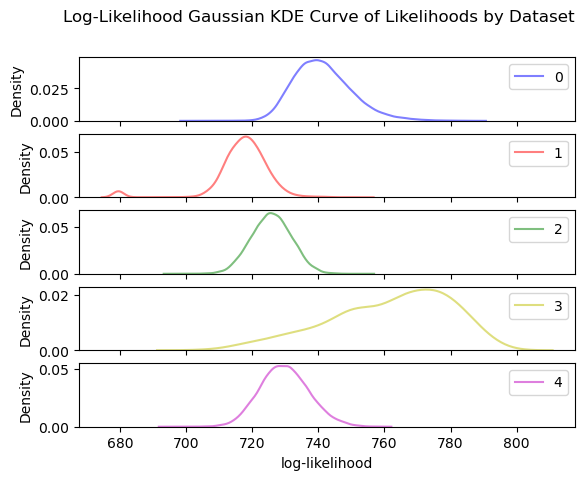

In [15]:
plot_likelihoods_pd(lowT_pd, "round", [0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


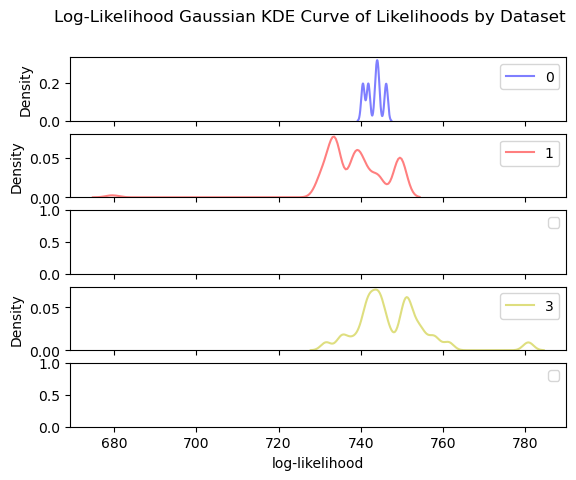

In [16]:
plot_likelihoods_pd(zeroT_pd, "round", [0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

In [26]:
lowT_pd[lowT_pd["round"] == 4].sort_values("likelihood", ascending=False).head(200)

sequence  round  likelihood
36575  GGTAGTGGTTTGGTTGGGGGGGTTTGTTAGGTGTTTGTGG      4  758.865555
20491  GGGTTGTGGGTTAGGGGGGGTTTAGGTAGTTTAGGTATGG      4  758.480590
32492  AGGGGTTGGGGGGGGTTTGTTTAGGTTTATGGGTTGGTCA      4  757.815208
14075  GTGGGTTTTAGGGGGGGGGGAGTGTTTGGTTTTTTGTTTA      4  757.770517
16533  AGGGGGTGGGGTTGTAGGGGTTTATGGTTTGGTTTGGTTG      4  757.315495
...                                         ...    ...         ...
39287  GGGTGTAGGCTGTGGGTGTAGTTGGTTAGGTTTAGGTCCT      4  747.538344
5842   GGCGCAGGGGGTGGGGGGTTTTATGTTTCGTTGGTTAATG      4  747.532260
4903   GGTGGGAGTGGGGGTTGTTGGGTGTGTATTTCGTTGTTCG      4  747.502695
36600  GGGGGGGGGTTGACTTATGTTTTGGGTTGGGGACTTGGTG      4  747.493904
22947  AGGGTGGGGGTGGTTTGAGGGGTAGTCTTTGTTAGTTACT      4  747.492418

[200 rows x 3 columns]

In [19]:
zeroT_pd[zeroT_pd["round"] == 1].sort_values("likelihood", ascending=False).head(200)

sequence  round  likelihood
2500  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2829  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2842  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2841  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2840  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
...                                        ...    ...         ...
2900  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2899  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2898  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2897  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406
2896  CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG      0  746.197406

[200 rows x 3 columns]

In [24]:
from functools import reduce

r11_data = all_data[all_data["round"] == "r11"]

def get_common_vals(pd1, pd2, key):
    """Takes two pandas dataframes, and return list of shared values in each dataframe column specified by optional parameter key"""
    return list(reduce(set.intersection, map(set, [pd1[key], pd2[key]])))

common_seqs_r3_r11 = get_common_vals(r11_data, r3_data, "sequence")
common_seqs_lowT_r11 = get_common_vals(r11_data, lowT_pd, "sequence")
common_seqs_zeroT_r11 = get_common_vals(r11_data, zeroT_pd, "sequence")
common_seqs_zeroT_r3 = get_common_vals(r3_data, zeroT_pd, "sequence")
common_seqs_lowT_r3 = get_common_vals(r3_data, lowT_pd, "sequence")


print(len(common_seqs_zeroT_r11), len(common_seqs_lowT_r11), len(common_seqs_zeroT_r3), len(common_seqs_lowT_r3))

0 0 0 0


In [89]:
3

250000

In [82]:
r11_data.shape[0]

301571

In [90]:
print(len(common_seqs_lowT))
print(len(common_seqs_zeroT))

0
0


In [ ]:
segments = [1, 2, 3, 4, 5]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood_r11"] = r3_likelihoods["likelihoods"]["r11"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=(670, 820))

In [67]:
seqs, hiddens = utils.gen_data_lowT(r12_crbm, beta=1, which = 'marginal' ,Nchains=20, Lchains=500, Nthermalize=0, Nstep=1, N_PT=1, reshape=True, update_betas=False)

In [68]:
gen_data_pd = seqs.detach()
input_gen = prepare_input_vector(r12_crbm, gen_data_pd)
X_gen = scaler.transform(input_gen)
pca_generated = pca.transform(X_gen)
clusters_gen = kmeans_pca.predict(pca_generated)

In [69]:
def cat_to_seq(categorical_tensor):
    cat_ten = categorical_tensor.numpy()
    int_to_base = {0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: '-'}
    seqs = []
    for i in range(categorical_tensor.shape[0]):
        seq = ""
        for j in range(categorical_tensor.shape[1]):
            seq += int_to_base[cat_ten[i][j]]
        seqs.append(seq)
    return seqs

gen_seqs = cat_to_seq(gen_data_pd.argmax(-1))

In [70]:
gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
gen_likelihoods = r12_crbm.predict(gen_seqs_input_pd)

In [71]:
gen_full_pd = gen_seqs_input_pd
gen_full_pd["likelihood"] = gen_likelihoods[1]

gen_likelihood_dict = {}
clusters = np.arange(1, 8)
for cluster in clusters:
    cluster_subset = gen_full_pd[gen_full_pd["round"] == cluster]
    likelihoods = cluster_subset.likelihood.tolist()
    gen_likelihood_dict[cluster] = likelihoods

No handles with labels found to put in legend.
No handles with labels found to put in legend.


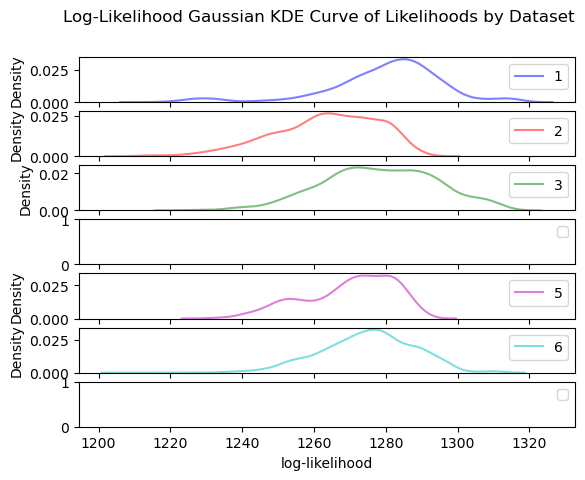

In [72]:
am.plot_likelihoods(gen_likelihood_dict, clusters, clusters)

In [87]:
# Let's classify each of the experimental sequences in a cluster
exp_seqs = {
    "SP5_sup": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP5_pap": '-ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTTG',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7_sup": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP7_pap": "-AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        # new_char = np.random.choice(["A", "C", "G", "T"])
        new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs
rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
rand_exp_pd = pd.DataFrame(rand_exp_set)

In [88]:
input_exp = prepare_input_vector(r12_crbm, rand_exp_pd)
X_exp = scaler.transform(input_exp)
pca_exp = pca.transform(X_exp)
clusters_exp = kmeans_pca.predict(pca_exp)
_, exp_r12_likelihoods = r12_crbm.predict(rand_exp_pd)
print(clusters_exp)

[5 5 5 5 5 5 5 5 5 0]


SP5 1278.2952021701003
SP6 1277.5987851952877
SP7 1273.983184315899
SP6C 1272.2539308398236
SP634 1250.1074460143745
SP634G 1248.1686831422721
SP634C 1242.1351936718138
SP634A 1238.205802402089
SP630 1241.8425745136055
SP619 1240.9896687986911


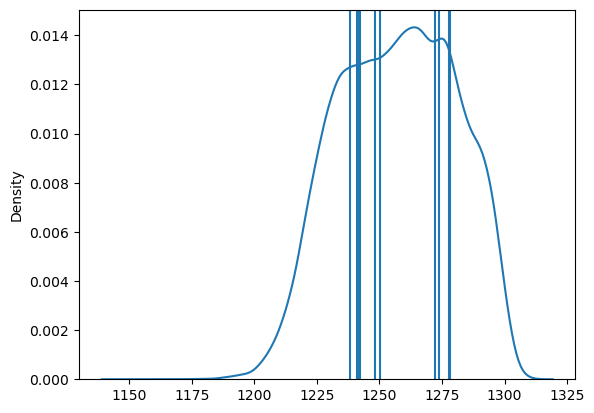

In [89]:
fig, axs = plt.subplots(1, 1)
sns.kdeplot(x=likelihood_dict["6"])


for iid, i in enumerate(new_exp_seqs.keys()):
    print(i, exp_r12_likelihoods[iid])
    plt.axvline(exp_r12_likelihoods[iid])

plt.show()

In [91]:
r12_pd = all_data[all_data["round"] == "r12"] # r12_data
r12_pd["cluster"] = df_pca_kmeans["Segment"].tolist()
r12_pd["likelihood"] = r12_likelihoods["likelihoods"]["r12"]

r12_c6_pd = r12_pd[r12_pd["cluster"] == "6"]

r12_highest = r12_c6_pd[r12_c6_pd["likelihood"] > 1285]
r12_mid = r12_c6_pd[r12_c6_pd["likelihood"] > 1250]

<ipython-input-91-1cdc2f7d2c30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_pd["cluster"] = df_pca_kmeans["Segment"].tolist()
<ipython-input-91-1cdc2f7d2c30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_pd["likelihood"] = r12_likelihoods["likelihoods"]["r12"]


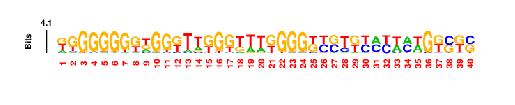

In [93]:
sl = am.seq_logo(r12_highest, "r12_c6_high_likeli", weight=False, outdir="./generated/")
fig, axs = plt.subplots(1, 1)
am.seqlogo_subplot(axs, sl, type="info")
plt.show()

In [98]:
r12_c6_pd.head()

sequence  copynum round assignment  \
5   ATAATGTTAACAATGGGGGGTGGGAAGGGTAGGGGGTCGT      1.0   r12          L   
16  CTATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGCTG      1.0   r12          L   
26  CTGGGGGGTGGGTCTGGGTATGGGGTCTGCACTATAGCTC      1.0   r12          L   
37  CCCATGTATGTTATTGATTGTTTGGATTTGTGGGCTTGAT      1.0   r12          L   
62  AAGGAGGGTAGGTAGTGCTCGGTAGGGAAACTCTGCCGAT      1.0   r12          L   

   cluster   likelihood  
5        6  1256.347018  
16       6  1259.633689  
26       6  1271.011836  
37       6  1243.485433  
62       6  1262.474035

In [100]:
r12_c6_pd_by_copynum = r12_c6_pd.sort_values("copynum", axis=0, ascending=False)
r12_c6_pd_by_copynum.head()

sequence   copynum round assignment  \
175772  AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT  650339.0   r12          H   
137124  AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT  445204.0   r12          H   
404130  AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGATT   75423.0   r12          H   
354587  AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGAT   50745.0   r12          H   
83248   CACGTTGTACACTGGGGGGTGGGAAGGGCTGGGTCCAGAT   20817.0   r12          H   

       cluster   likelihood  
175772       6  1290.505682  
137124       6  1290.425812  
404130       6  1286.164744  
354587       6  1284.713516  
83248        6  1236.024896

In [102]:
r12_c6_pd_by_likelihood = r12_c6_pd.sort_values("likelihood", axis=0, ascending=False)
r12_c6_pd_by_likelihood.head(20)

sequence  copynum round assignment  \
469351  AGGCTTATCGTCAGGGGGGTGGTTCCGGTTTTGGGGTCGT      3.0   r12          L   
401986  TTGGGGGGTGGGTTGGTTTTTGGGTCGTTTCTACAGTGGG      1.0   r12          L   
447627  GGGGGGGGGGGGTTGGGTTTTGGGTTCTGCACTATGGCTC      2.0   r12          L   
81619   AGGCTTATCGTCAGGGGGATGGGTTCGGGTTTGGGGTCGT      1.0   r12          L   
516505  TGGGGGGGGGGGTTGGGTTTTGGGTTCTGCACTATGGCTC      1.0   r12          L   
299840  TGGGGGGTGGGTTTTGTTTTGGGGCTCCGCACTATGGCTC      1.0   r12          L   
488396  GGGGGGGGGGTTTTGGTTAGGGGGTCGTTTCTACAGTGGG      1.0   r12          L   
287880  TTGGGGGGAGGGTAGGGTTTTGGGTCGTTTCTACAGTGGG      1.0   r12          L   
223447  GGGGGGGGTGGTTTGGTTTGGGGGTCGTTTCTACAGTGGG      2.0   r12          L   
65221   GGGGGGGTAGGGTAGGTTATTGGGTCGTTTCTACAGTGGG      1.0   r12          L   
325585  GGGGGGGTGGTTTTGGGTTGGGGGTCGTTTCTACAGTGGG      3.0   r12          L   
41056   GGGGGGGTGGGTTTGGGTTTGGGGCTCTGCACTATGGCTC      1.0   r12          L   
30407   GGGGGGGTGGGTTTGGTTTGGGGGTCGTTTCTACAGTGGG      1.0   r12          L   
56860   AGGTTTATCTTTTGGGGGGTGGGTCCGGTTTTGGGGTCGT      1.0   r12          L   
257820  GGGGGGGTGGGTTTTGGTTTGGGGCTCCGCACTATGGCTC      1.0   r12          L   
423841  GGGGGGGGGGGGTTGGTTTTTGGGTTCTGCACTATGGCTC      1.0   r12          L   
233739  AGGCTTATCGTAAGGGGGATGGGTCCGGGTTTGGGGTCGT      1.0   r12          L   
610127  GGGGGGGGTGGTTTGGTTAGGGGGTCGTTTCTACAGTGGG      2.0   r12          L   
481088  AGGCTTATCGTCAGGGGGGTGGTTCCGGTTTAGGGGTCGT      2.0   r12          L   
509633  ATGGGGGTAGGGAAGTTTATTGGGTCGTTTCTACAGTGGG      1.0   r12          L   

       cluster   likelihood  
469351       6  1311.647367  
401986       6  1310.213880  
447627       6  1310.170770  
81619        6  1310.131038  
516505       6  1309.958333  
299840       6  1309.945164  
488396       6  1309.818671  
287880       6  1309.294048  
223447       6  1309.162330  
65221        6  1309.152644  
325585       6  1309.043244  
41056        6  1308.956537  
30407        6  1308.780733  
56860        6  1308.690257  
257820       6  1308.687421  
423841       6  1308.679466  
233739       6  1308.202182  
610127       6  1307.866116  
481088       6  1307.773436  
509633       6  1307.640545

In [ ]:
# import scipy
#
# def monoExp(x, m, t, b):
#     return m * np.exp(-t * x) + b
#
# p0 = (2000, .1, 50) # start with values near those we expect
# params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
# m, t, b = params

In [103]:
def log(x):
    return math.log(x+0.0001)

r12_c6_pd["log_copynum"] = r12_c6_pd["copynum"].map(log)

<ipython-input-103-42975cf7f062>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_c6_pd["log_copynum"] = r12_c6_pd["copynum"].map(log)


In [106]:
r12_c6_pd.sort_values("log_copynum", axis=0, ascending=True).head()

sequence  copynum round assignment  \
5       ATAATGTTAACAATGGGGGGTGGGAAGGGTAGGGGGTCGT      1.0   r12          L   
412344  GGGGGGGTTGGGTTTGGTTTTGGGTTCTGCACTATGGCTC      1.0   r12          L   
412361  GTAGGTGAGTAGGTGCTTTTAGGTGTTAGTGATAGGACTA      1.0   r12          L   
412363  GGGGGGGGTGGGTTGTTTTTGGGGTCGTTTCTACAGTGGG      1.0   r12          L   
412365  TCGGGGGGTGGGCTTGGGTATAGGGTCTGCACTATGGCTC      1.0   r12          L   

       cluster   likelihood  log_copynum  
5            6  1256.347018       0.0001  
412344       6  1303.069770       0.0001  
412361       6  1218.722540       0.0001  
412363       6  1302.419006       0.0001  
412365       6  1284.631532       0.0001

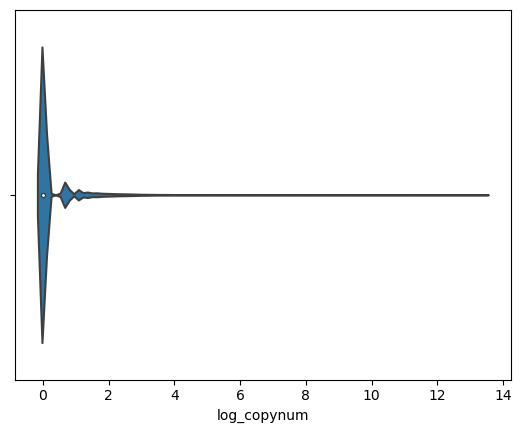

In [107]:
sns.violinplot(data=r12_c6_pd, x="log_copynum")
plt.show()

In [108]:
r12_c6_pd["log_copynum"].sum()

18114.26577846481

In [46]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

cluster_method = "db"
if cluster_method == "db":
    alg = DBSCAN(eps=1.8, metric='euclidean', min_samples=5000).fit(input_processed)
    core_samples_mask = np.zeros_like(alg.labels_, dtype=bool)
    core_samples_mask[alg.core_sample_indices_] = True

elif cluster_method == "op":
    alg = OPTICS(min_samples=2000, metric="euclidean").fit(input_processed)
    # core_distance_mask = np.zeros_like(alg.labels_, dtype=bool)
    # core_samples_mask[alg.core_sample_indices_] = True


labels = alg.labels_

In [48]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
cluster_id = set(labels)
for clust in cluster_id:
    print('Clust', clust, 'Length', list(labels).count(clust))

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Clust 0 Length 64206
Clust 1 Length 29728
Clust 2 Length 217801
Clust 3 Length 72241
Clust 4 Length 66688
Clust 5 Length 25061
Clust 6 Length 4459
Clust 7 Length 11366
Clust 8 Length 8262
Clust 9 Length 8348
Clust 10 Length 9604
Clust 11 Length 2128
Clust 12 Length 2212
Clust 13 Length 1143
Clust -1 Length 127694
Estimated number of clusters: 14
Estimated number of noise points: 127694


In [ ]:
# Now we should try to visualize each clusters sequence logo

r12_db_data = r12_data
r12_db_data["cluster"] = list(labels)

# Generate Sequence Logo for Each Cluster
db_paths_u, db_paths_w = [], []
for clust in cluster_id:
    db_paths_u.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=False, outdir="./generated/"))
    db_paths_w.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{db_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{db_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()



In [27]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=7, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components_4)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r12_data.reset_index(drop=True), pd.DataFrame(principal_components_4)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'first', 1:'second', 2:"third", 3:'fourth', 4:'fifth', 5:"sixth", 6:"seventh", 7:"eighth"})

/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


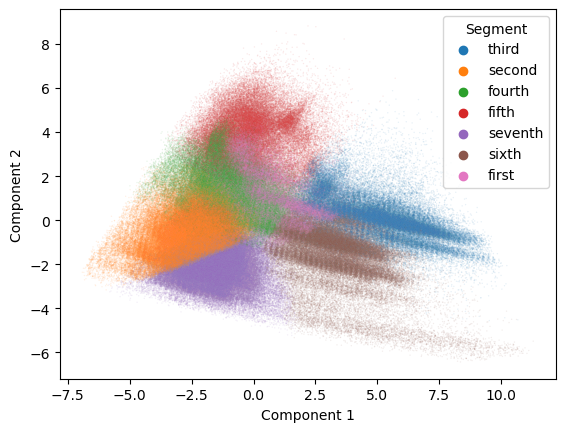

In [28]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

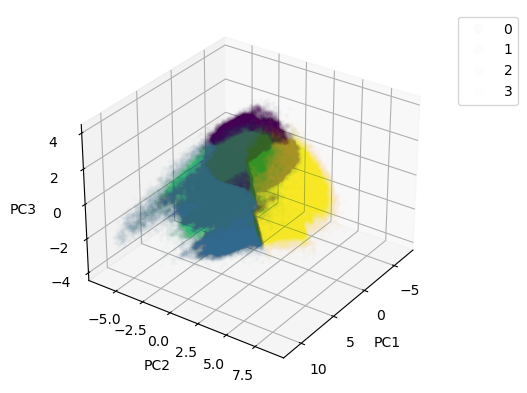

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 35)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

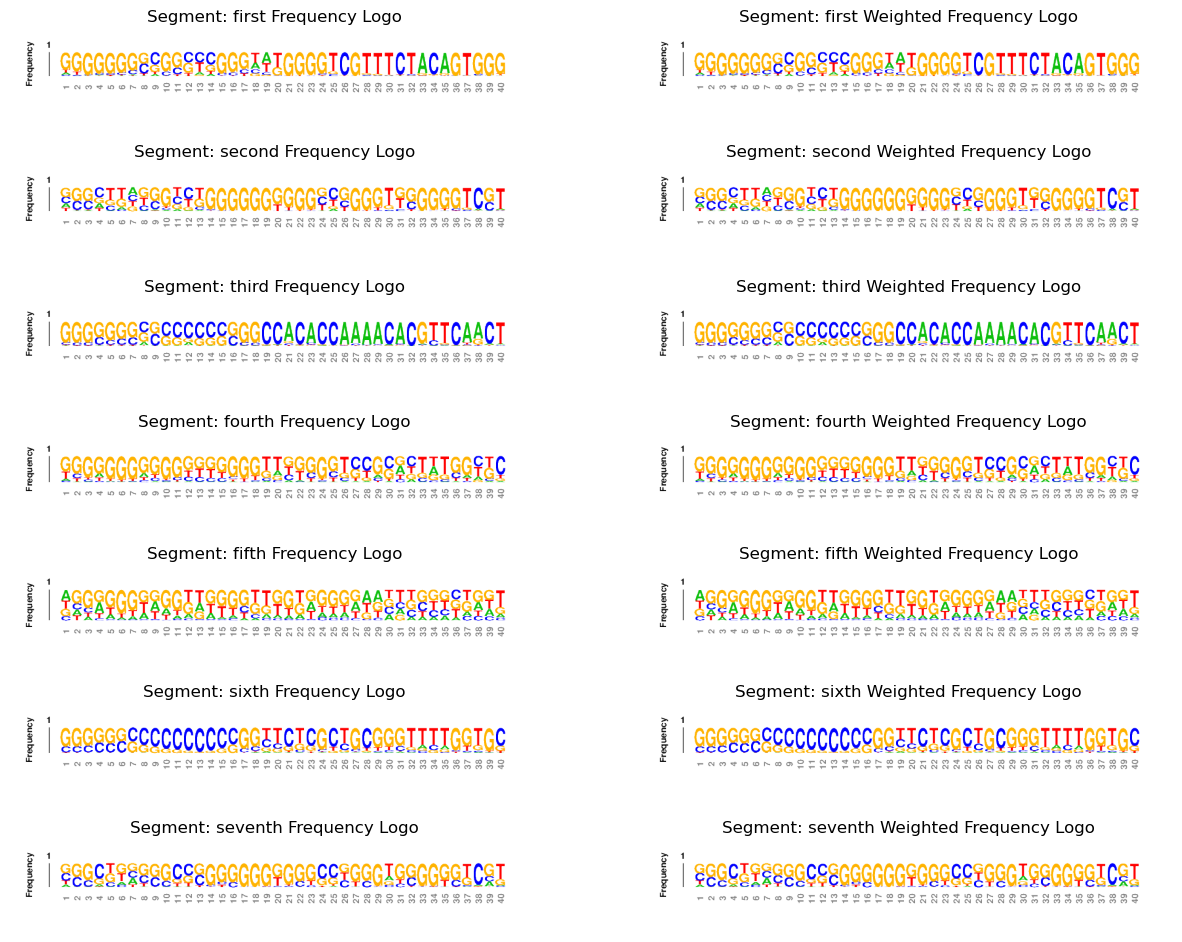

In [30]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

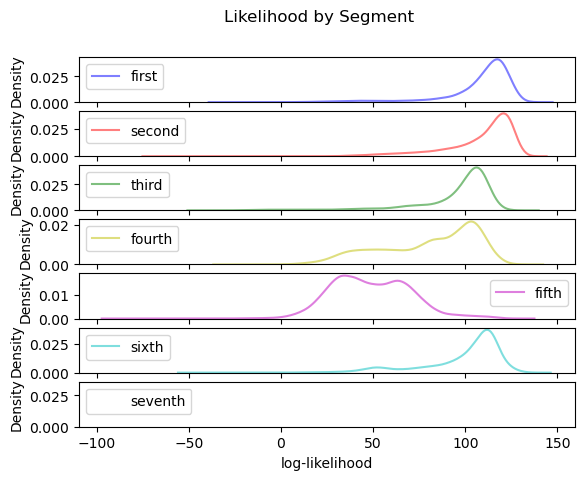

In [39]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = r12_likelihoods["likelihoods"]["r12"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

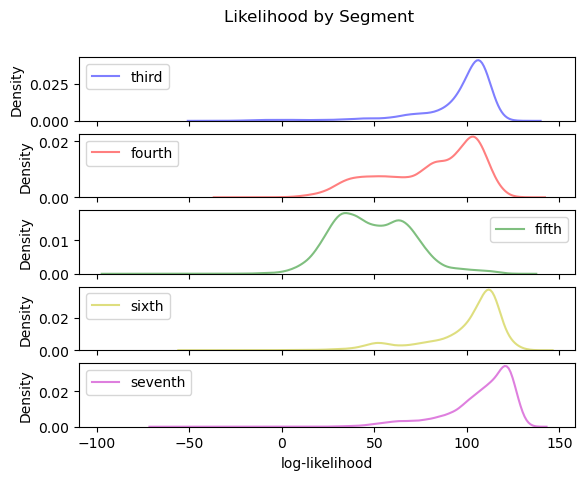

In [40]:
am.plot_likelihoods(likelihood_dict, segments[-5:], segments[-5:], title="Likelihood by Segment", xlim=None)

In [ ]:
am.plot_likelihoods(r12_likelihoods["likelihoods"], segments, segments, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False)